In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import welch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Set paths
base_path = '/kaggle/input/mtcaic3'
train_csv = os.path.join(base_path, 'train.csv')
validation_csv = os.path.join(base_path, 'validation.csv')

# Load data and filter for MI tasks
train_df = pd.read_csv(train_csv)
validation_df = pd.read_csv(validation_csv)
mi_train = train_df[train_df['task'] == 'MI'].copy()
mi_validation = validation_df[validation_df['task'] == 'MI'].copy()

# Function to load trial EEG data
def load_trial_data(row, base_path):
    dataset = 'train' if row['id'] <= 4800 else 'validation'
    eeg_path = os.path.join(
        base_path, 
        row['task'], 
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    eeg_data = pd.read_csv(eeg_path)
    start_idx = (row['trial'] - 1) * 2250
    return eeg_data.iloc[start_idx:start_idx + 2250]

# Function to compute mu-band power (8-12 Hz)
def compute_mu_power(signal, fs=250):
    f, Pxx = welch(signal, fs=fs, nperseg=fs)
    mu_band = (f >= 8) & (f <= 12)
    return np.mean(Pxx[mu_band])

# Function to extract 1-7s window and compute features
def process_trial(trial_data):
    # Select 1-7s window (250-1750 samples)
    trial_window = trial_data.iloc[250:1750]
    eeg_data = trial_window[['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']]
    c3_power = compute_mu_power(eeg_data['C3'].values)
    c4_power = compute_mu_power(eeg_data['C4'].values)
    return eeg_data.values, c3_power, c4_power

# Process training data
X_train, y_contra_train = [], []
for _, row in mi_train.iterrows():
    trial_data = load_trial_data(row, base_path)
    eeg_window, c3_power, c4_power = process_trial(trial_data)
    asymmetry = c4_power - c3_power
    
    # Annotate contralateral pattern
    if (row['label'] == 'Right' and asymmetry > 0) or (row['label'] == 'Left' and asymmetry < 0):
        y_contra_train.append(1)  # Follows pattern
    else:
        y_contra_train.append(0)   # Does not follow pattern
    X_train.append(eeg_window)

# Process validation data
X_val, y_contra_val = [], []
for _, row in mi_validation.iterrows():
    trial_data = load_trial_data(row, base_path)
    eeg_window, c3_power, c4_power = process_trial(trial_data)
    asymmetry = c4_power - c3_power
    
    if (row['label'] == 'Right' and asymmetry > 0) or (row['label'] == 'Left' and asymmetry < 0):
        y_contra_val.append(1)
    else:
        y_contra_val.append(0)
    X_val.append(eeg_window)

# Convert to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_contra_train = np.array(y_contra_train)
y_contra_val = np.array(y_contra_val)

2025-06-30 06:01:29.986604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751263290.231920      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751263290.292987      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training Set Class Distribution:
Class 0 (Non-contralateral): 1148 samples (47.83%)
Class 1 (Contralateral): 1252 samples (52.17%)

Validation Set Class Distribution:
Class 0 (Non-contralateral): 23 samples (46.00%)
Class 1 (Contralateral): 27 samples (54.00%)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


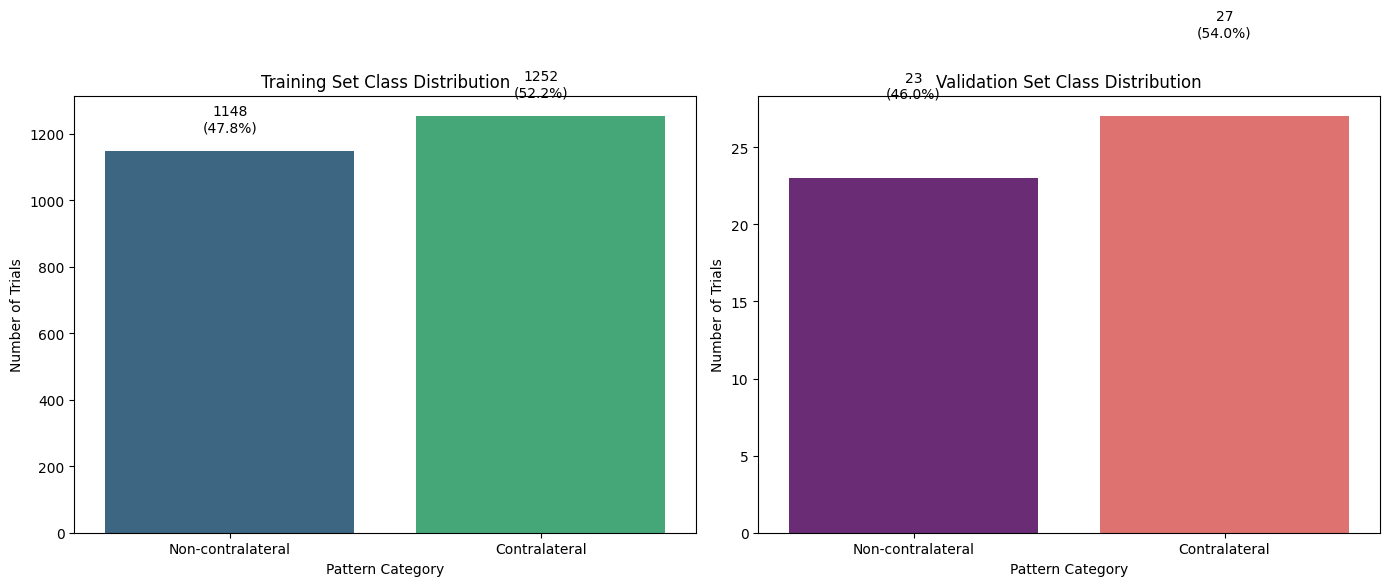


Training Set Class Ratio (Positive:Negative): 1:0.92
Validation Set Class Ratio (Positive:Negative): 1:0.85

Class distribution is relatively balanced


In [5]:
# Check class distribution
print("Training Set Class Distribution:")
unique_train, counts_train = np.unique(y_contra_train, return_counts=True)
train_dist = dict(zip(unique_train, counts_train))
print(f"Class 0 (Non-contralateral): {train_dist.get(0, 0)} samples ({train_dist.get(0, 0)/len(y_contra_train)*100:.2f}%)")
print(f"Class 1 (Contralateral): {train_dist.get(1, 0)} samples ({train_dist.get(1, 0)/len(y_contra_train)*100:.2f}%)")

print("\nValidation Set Class Distribution:")
unique_val, counts_val = np.unique(y_contra_val, return_counts=True)
val_dist = dict(zip(unique_val, counts_val))
print(f"Class 0 (Non-contralateral): {val_dist.get(0, 0)} samples ({val_dist.get(0, 0)/len(y_contra_val)*100:.2f}%)")
print(f"Class 1 (Contralateral): {val_dist.get(1, 0)} samples ({val_dist.get(1, 0)/len(y_contra_val)*100:.2f}%)")

# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Training set
sns.barplot(x=['Non-contralateral', 'Contralateral'], 
            y=[train_dist.get(0, 0), train_dist.get(1, 0)], 
            ax=ax[0], palette='viridis')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_ylabel('Number of Trials')
ax[0].set_xlabel('Pattern Category')
for i, count in enumerate([train_dist.get(0, 0), train_dist.get(1, 0)]):
    ax[0].text(i, count+50, f'{count}\n({count/len(y_contra_train)*100:.1f}%)', 
              ha='center', va='bottom')

# Validation set
sns.barplot(x=['Non-contralateral', 'Contralateral'], 
            y=[val_dist.get(0, 0), val_dist.get(1, 0)], 
            ax=ax[1], palette='magma')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_ylabel('Number of Trials')
ax[1].set_xlabel('Pattern Category')
for i, count in enumerate([val_dist.get(0, 0), val_dist.get(1, 0)]):
    ax[1].text(i, count+5, f'{count}\n({count/len(y_contra_val)*100:.1f}%)', 
              ha='center', va='bottom')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300)
plt.show()

# Calculate imbalance ratios
train_ratio = train_dist.get(1, 1) / train_dist.get(0, 1) if 0 in train_dist else 1
val_ratio = val_dist.get(1, 1) / val_dist.get(0, 1) if 0 in val_dist else 1

print(f"\nTraining Set Class Ratio (Positive:Negative): 1:{1/train_ratio:.2f}")
print(f"Validation Set Class Ratio (Positive:Negative): 1:{1/val_ratio:.2f}")

# Recommendation based on imbalance
if min(counts_train) / max(counts_train) < 0.7:
    print("\nWarning: Significant class imbalance detected!")
    print("Recommendations:")
    print("1. Use class weighting in model training")
    print("2. Consider oversampling minority class or undersampling majority class")
    print("3. Use data augmentation techniques")
    
    # Calculate class weights for model training
    weight_for_0 = (1 / train_dist.get(0, 1)) * (len(y_contra_train) / 2.0)
    weight_for_1 = (1 / train_dist.get(1, 1)) * (len(y_contra_train) / 2.0)
    class_weights = {0: weight_for_0, 1: weight_for_1}
    
    print(f"\nSuggested class weights: {class_weights}")
else:
    print("\nClass distribution is relatively balanced")

In [2]:
def create_cnn_model(input_shape):
    model = models.Sequential([
        # Input shape: (1500 timepoints, 8 channels)
        layers.Reshape((1500, 8, 1), input_shape=input_shape),
        
        # Convolutional blocks
        layers.Conv2D(16, (50, 1), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 1)),
        
        layers.Conv2D(32, (25, 1), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 1)),
        
        layers.Conv2D(64, (10, 1), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 1)),
        
        layers.Conv2D(128, (5, 1), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 1)),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize model
input_shape = (1500, 8)  # 1500 samples x 8 channels
model = create_cnn_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1751263504.525589      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 1500, 8, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1500, 8, 16)         │             816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1500, 8, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 750, 8, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 750, 8, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 750, 8, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 375, 8, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 375, 8, 64)          │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 375, 8, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 187, 8, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 187, 8, 128)         │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 187, 8, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 93, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 95232)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,094,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,171,217 (23.54 MB)

 Trainable params: 6,170,737 (23.54 MB)

 Non-trainable params: 480 (1.88 KB)

In [3]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 30

# Train model
history = model.fit(
    X_train, y_contra_train,
    validation_data=(X_val, y_contra_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight={0: 1.0, 1: 1.0},  # Adjust if class imbalance exists
    verbose=1
)

Epoch 1/30


I0000 00:00:1751263510.498609      99 service.cc:148] XLA service 0x7c9228006b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751263510.499248      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751263510.997677      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


13/75 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4919 - loss: 9.3593 

I0000 00:00:1751263515.586023      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4907 - loss: 4.0798 - val_accuracy: 0.4600 - val_loss: 7.2002
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5152 - loss: 0.6930 - val_accuracy: 0.5400 - val_loss: 0.6914
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5417 - loss: 0.6923 - val_accuracy: 0.5400 - val_loss: 0.6920
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5036 - loss: 0.6932 - val_accuracy: 0.5400 - val_loss: 0.6919
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5279 - loss: 0.6923 - val_accuracy: 0.5400 - val_loss: 0.6916
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5170 - loss: 0.6927 - val_accuracy: 0.5400 - val_loss: 0.6914
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5315 - loss: 0.6918 - val_accuracy: 0.5400 - val_loss: 0.6912
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5364 - loss: 0.6914 - val_accuracy: 0.5400 - val_loss: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5475 - loss: 0.6900

Validation Accuracy: 0.5400


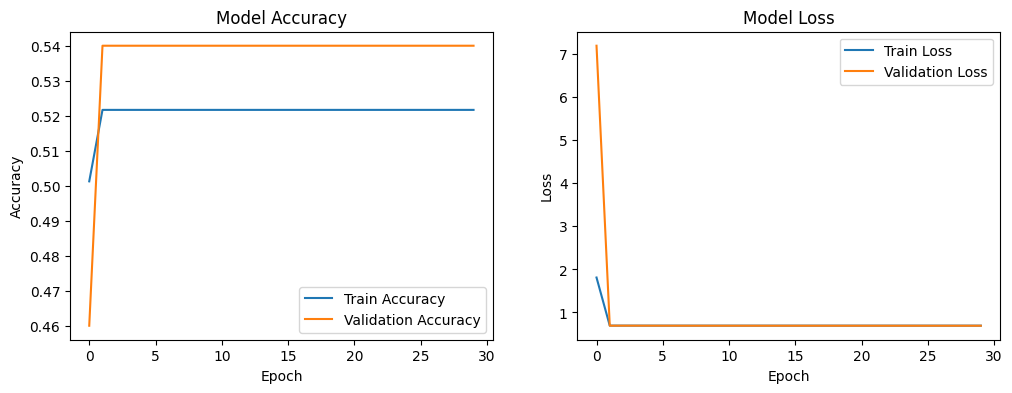

In [4]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_contra_val)
print(f'\nValidation Accuracy: {val_acc:.4f}')

# Plot training history (requires matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

100%|██████████| 200/200 [00:11<00:00, 17.14it/s]



Overall Channel Statistics:
                  mean                         std               \
                  mean            std         mean          std   
channel                                                           
C3       299669.828421   27600.469229   859.473884  1448.689915   
C4       317985.476135   74097.133329  1369.647634  1626.961017   
CZ       327352.447456   63971.317472  1736.155976  2913.734064   
FZ       296980.600459   23673.847088  1089.652097  1888.659253   
OZ       283128.226036   31110.696402   860.840193   968.957868   
PO7      285741.667937   29635.867882   611.804042   768.629198   
PO8      283200.055213   29030.366813   717.700395   678.679301   
PZ       341496.827171  116774.486791  1568.335512  1608.364047   

                   min            max        range  
                  mean           mean         mean  
channel                                             
C3       298041.198984  301250.145078  3208.946094  
C4       315553.08031

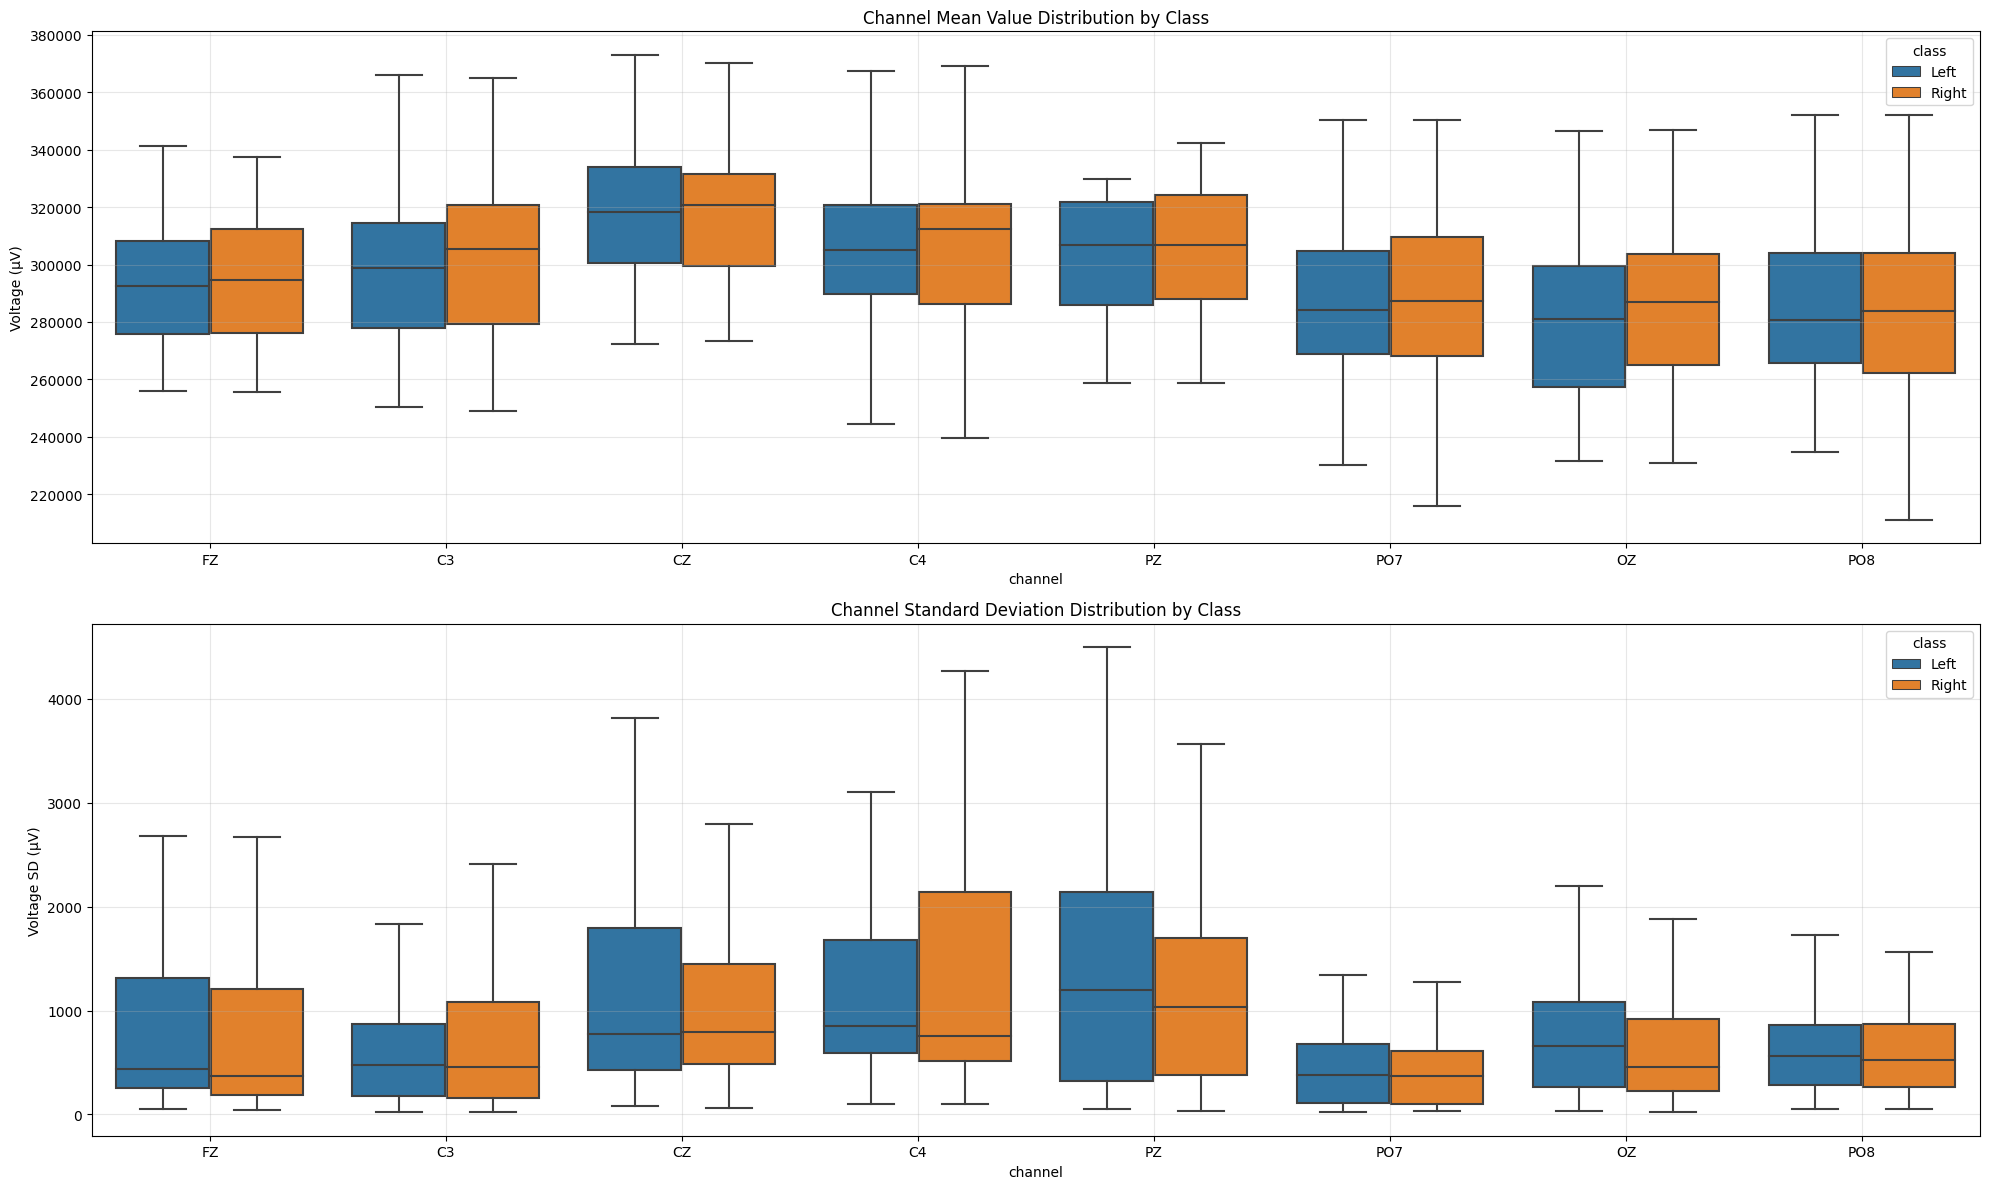

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

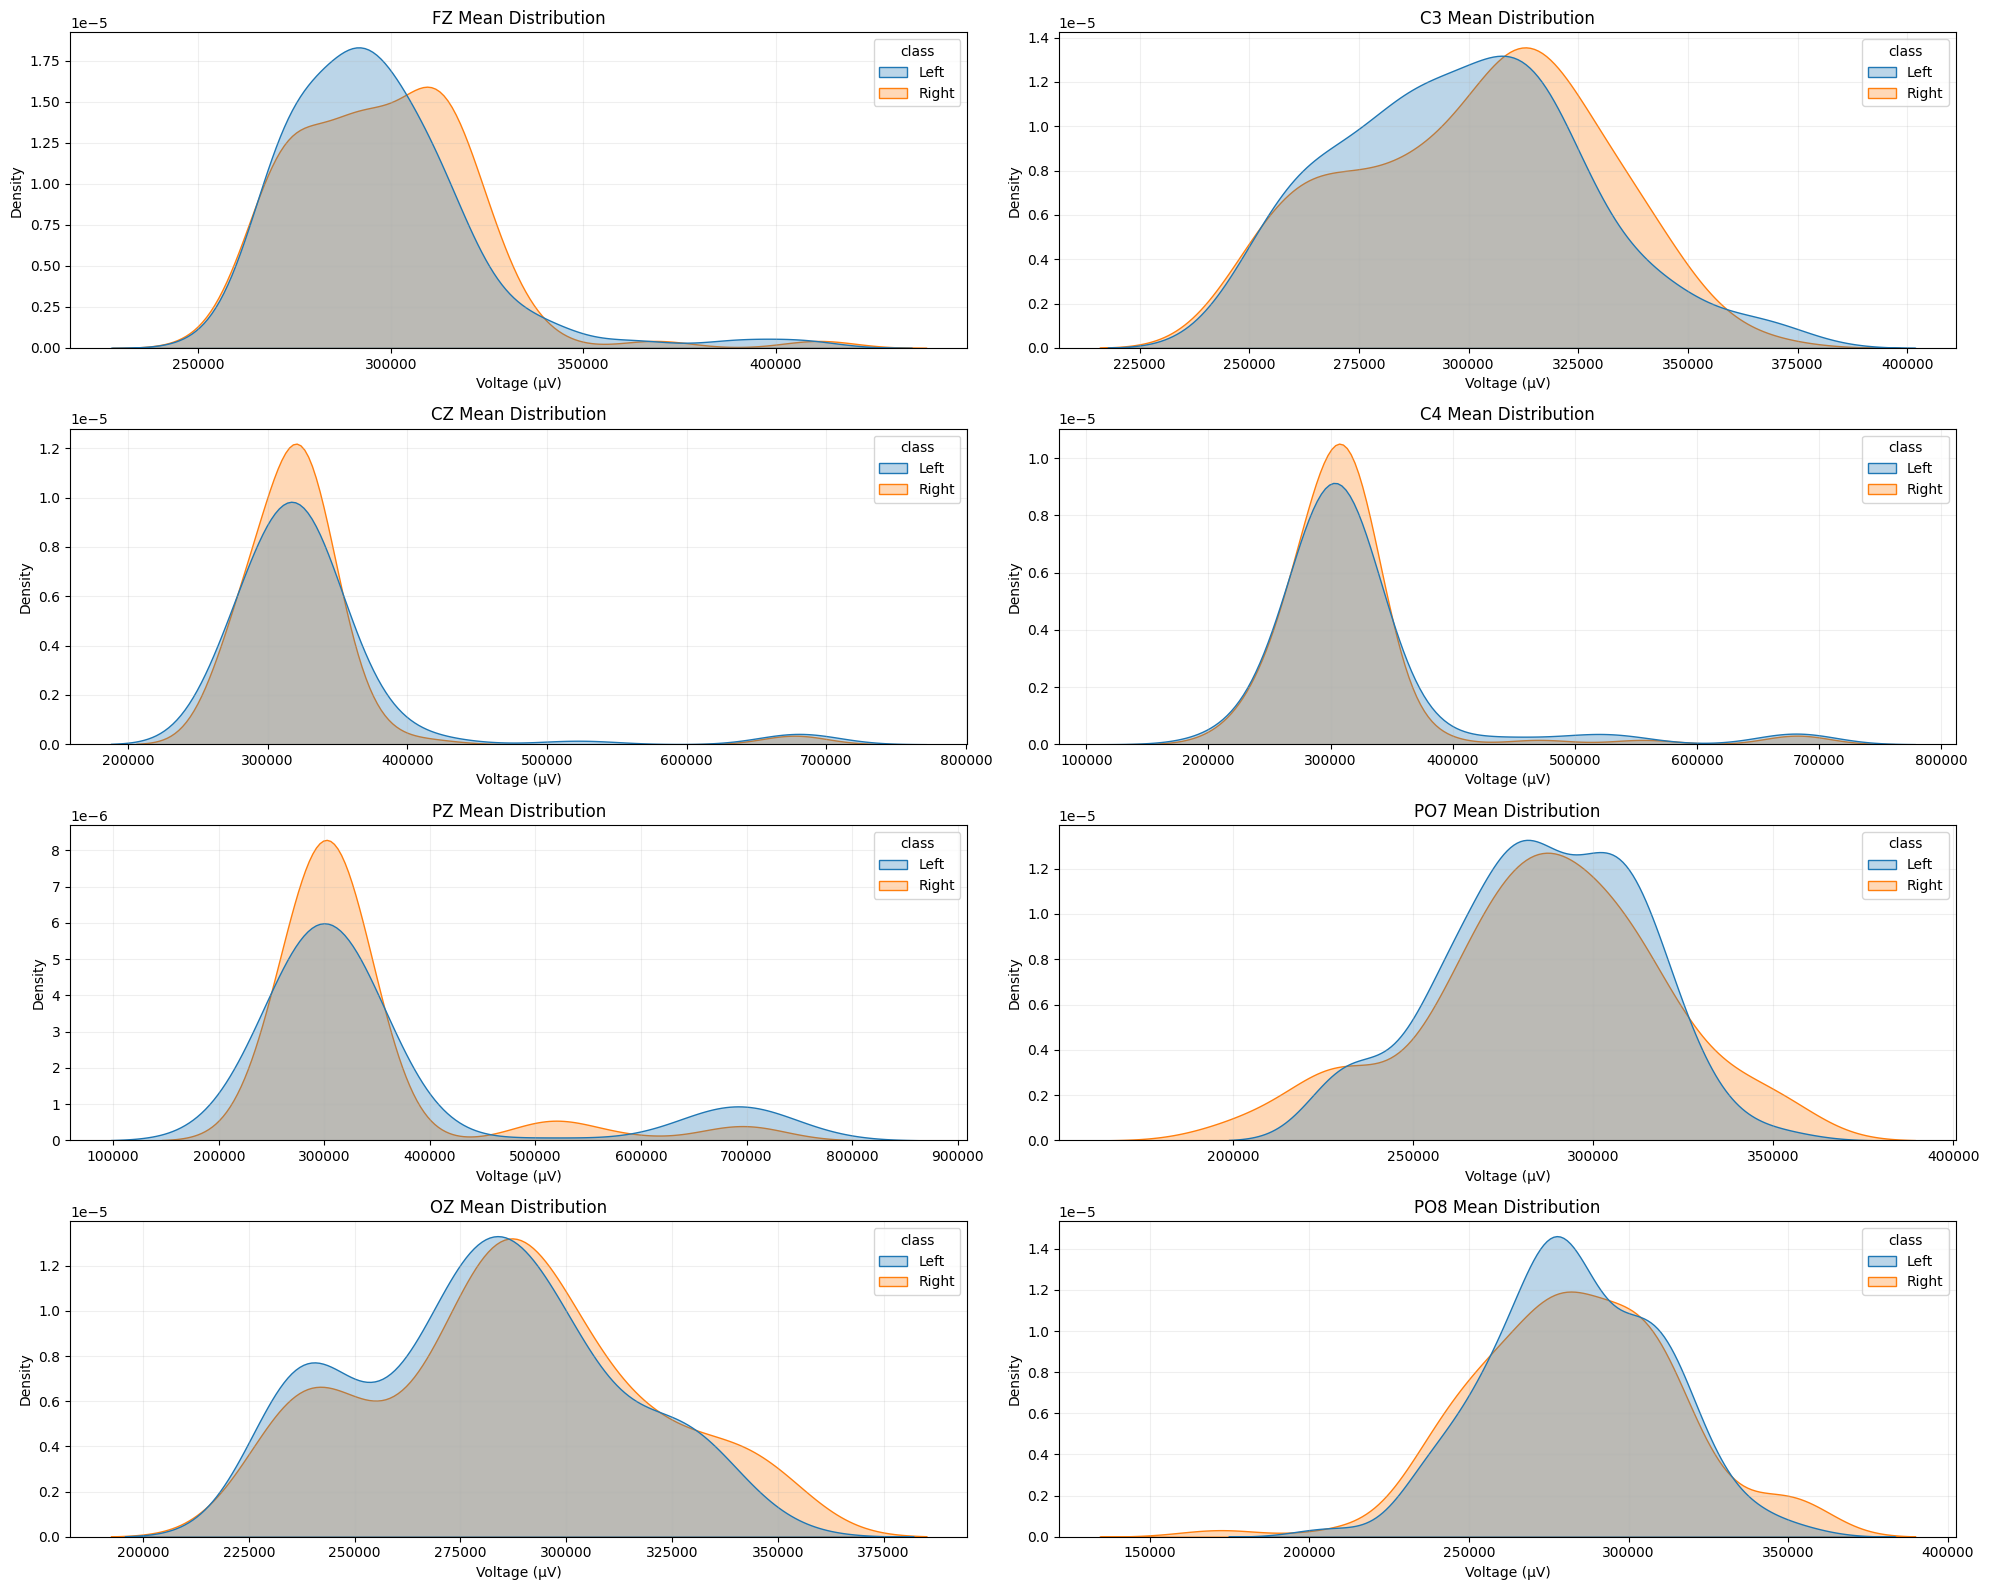


Key Distribution Differences:

FZ Channel:
  Mean difference (Left-Right): -1901.9125 μV
  STD difference (Left-Right): 197.0173 μV
  Left mean: 296029.6442 μV | Right mean: 297931.5567 μV
  Left STD: 1188.1607 | Right STD: 991.1434

C3 Channel:
  Mean difference (Left-Right): -2976.4026 μV
  STD difference (Left-Right): -98.0264 μV
  Left mean: 298181.6271 μV | Right mean: 301158.0297 μV
  Left STD: 810.4607 | Right STD: 908.4871

CZ Channel:
  Mean difference (Left-Right): 7246.4518 μV
  STD difference (Left-Right): 180.0270 μV
  Left mean: 330975.6734 μV | Right mean: 323729.2216 μV
  Left STD: 1826.1695 | Right STD: 1646.1425

C4 Channel:
  Mean difference (Left-Right): 9244.6329 μV
  STD difference (Left-Right): -41.7636 μV
  Left mean: 322607.7926 μV | Right mean: 313363.1597 μV
  Left STD: 1348.7658 | Right STD: 1390.5294

PZ Channel:
  Mean difference (Left-Right): 22369.1904 μV
  STD difference (Left-Right): -34.5934 μV
  Left mean: 352681.4224 μV | Right mean: 330312.2320 μV

In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
BASE_PATH = "/kaggle/input/mtcaic3/"
TASK = "MI"
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLES_PER_TRIAL = 2250  # For MI (9s * 250Hz)
NUM_TRIALS_PER_CLASS = 100  # Number of trials to sample per class

# Load training data and filter for MI
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
mi_train = train_df[train_df['task'] == TASK]

# Sample trials from each class
left_trials = mi_train[mi_train['label'] == 'Left'].sample(NUM_TRIALS_PER_CLASS, random_state=42)
right_trials = mi_train[mi_train['label'] == 'Right'].sample(NUM_TRIALS_PER_CLASS, random_state=42)
sampled_trials = pd.concat([left_trials, right_trials])

# EEG Cache to avoid reloading session files
eeg_cache = {}

def load_trial_data_cached(row):
    """Load trial data with session-level caching"""
    # Determine dataset split based on ID
    dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
    
    # Create cache key
    cache_key = (row['task'], dataset, row['subject_id'], row['trial_session'])
    
    # Load session data if not cached
    if cache_key not in eeg_cache:
        session_path = os.path.join(
            BASE_PATH,
            row['task'],
            dataset,
            row['subject_id'],
            str(row['trial_session']),
            'EEGdata.csv'
        )
        eeg_cache[cache_key] = pd.read_csv(session_path)
    
    # Extract specific trial
    session_data = eeg_cache[cache_key]
    start_idx = (row['trial'] - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    return session_data.iloc[start_idx:end_idx]

# Extract features for each channel and trial
feature_rows = []

for _, row in tqdm(sampled_trials.iterrows(), total=len(sampled_trials)):
    trial_data = load_trial_data_cached(row)
    
    for channel in EEG_CHANNELS:
        ch_data = trial_data[channel]
        
        # Calculate distribution statistics
        stats = {
            'trial_id': row['id'],
            'subject': row['subject_id'],
            'class': row['label'],
            'channel': channel,
            'mean': np.mean(ch_data),
            'std': np.std(ch_data),
            'min': np.min(ch_data),
            'max': np.max(ch_data),
            'median': np.median(ch_data),
            'q1': np.quantile(ch_data, 0.25),
            'q3': np.quantile(ch_data, 0.75),
            'range': np.ptp(ch_data),
            'skew': pd.Series(ch_data).skew(),
            'kurtosis': pd.Series(ch_data).kurtosis()
        }
        feature_rows.append(stats)

# Create features DataFrame
features_df = pd.DataFrame(feature_rows)

# 1. Numerical Statistics Summary
print("\n" + "="*80)
print("Overall Channel Statistics:")
print("="*80)
print(features_df.groupby('channel').agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std'],
    'min': 'mean',
    'max': 'mean',
    'range': 'mean'
}))

print("\n" + "="*80)
print("Class-wise Channel Statistics:")
print("="*80)
class_channel_stats = features_df.groupby(['class', 'channel']).agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std']
})
print(class_channel_stats)

# 2. Box Plot Visualization
plt.figure(figsize=(20, 12))

# Mean values comparison
plt.subplot(2, 1, 1)
sns.boxplot(x='channel', y='mean', hue='class', data=features_df, showfliers=False)
plt.title('Channel Mean Value Distribution by Class')
plt.ylabel('Voltage (μV)')
plt.grid(True, alpha=0.3)

# Standard deviation comparison
plt.subplot(2, 1, 2)
sns.boxplot(x='channel', y='std', hue='class', data=features_df, showfliers=False)
plt.title('Channel Standard Deviation Distribution by Class')
plt.ylabel('Voltage SD (μV)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('channel_distributions.png')
plt.show()

# 3. Data Distribution Analysis (KDE Plots)
plt.figure(figsize=(20, 16))
for idx, channel in enumerate(EEG_CHANNELS, 1):
    plt.subplot(4, 2, idx)
    channel_data = features_df[features_df['channel'] == channel]
    sns.kdeplot(data=channel_data, x='mean', hue='class', fill=True, alpha=0.3, common_norm=False)
    plt.title(f'{channel} Mean Distribution')
    plt.xlabel('Voltage (μV)')
    plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig('density_distributions.png')
plt.show()

# 4. Statistical Comparison Report
print("\n" + "="*80)
print("Key Distribution Differences:")
print("="*80)
for channel in EEG_CHANNELS:
    left_data = features_df[(features_df['channel'] == channel) & (features_df['class'] == 'Left')]
    right_data = features_df[(features_df['channel'] == channel) & (features_df['class'] == 'Right')]
    
    mean_diff = left_data['mean'].mean() - right_data['mean'].mean()
    std_diff = left_data['std'].mean() - right_data['std'].mean()
    
    print(f"\n{channel} Channel:")
    print(f"  Mean difference (Left-Right): {mean_diff:.4f} μV")
    print(f"  STD difference (Left-Right): {std_diff:.4f} μV")
    print(f"  Left mean: {left_data['mean'].mean():.4f} μV | Right mean: {right_data['mean'].mean():.4f} μV")
    print(f"  Left STD: {left_data['std'].mean():.4f} | Right STD: {right_data['std'].mean():.4f}")

# 5. Statistical Test (Mann-Whitney U Test)
from scipy.stats import mannwhitneyu

print("\n" + "="*80)
print("Statistical Significance Testing (Mann-Whitney U):")
print("="*80)
for channel in EEG_CHANNELS:
    left_means = features_df[(features_df['channel'] == channel) & 
                            (features_df['class'] == 'Left')]['mean']
    right_means = features_df[(features_df['channel'] == channel) & 
                             (features_df['class'] == 'Right')]['mean']
    
    stat, pval = mannwhitneyu(left_means, right_means)
    print(f"{channel}: p-value = {pval:.6f} {'***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'}")

MI Trials - Train: 2400, Validation: 50, Test: 50


100%|██████████| 2500/2500 [00:32<00:00, 76.07it/s]



Overall Dataset Statistics:
                     mean                        std               \
                     mean           std         mean          std   
dataset                                                             
test        347996.918989  67502.727290  2230.946049  1923.165388   
train       308725.675737  65638.583999  1226.268638  1931.472898   
validation  322614.007574  80640.716964  2715.667665  3278.061186   

                      min            max        range      skew  kurtosis  
                     mean           mean         mean      mean      mean  
dataset                                                                    
test        344331.886562  351601.544063  7269.657500 -0.037538 -1.219369  
train       306581.621281  310851.550851  4269.929570  0.011431 -1.008521  
validation  318323.674219  326949.779023  8626.104805  0.030679 -1.227368  

Channel-wise Statistics Across Datasets:
                             mean                         

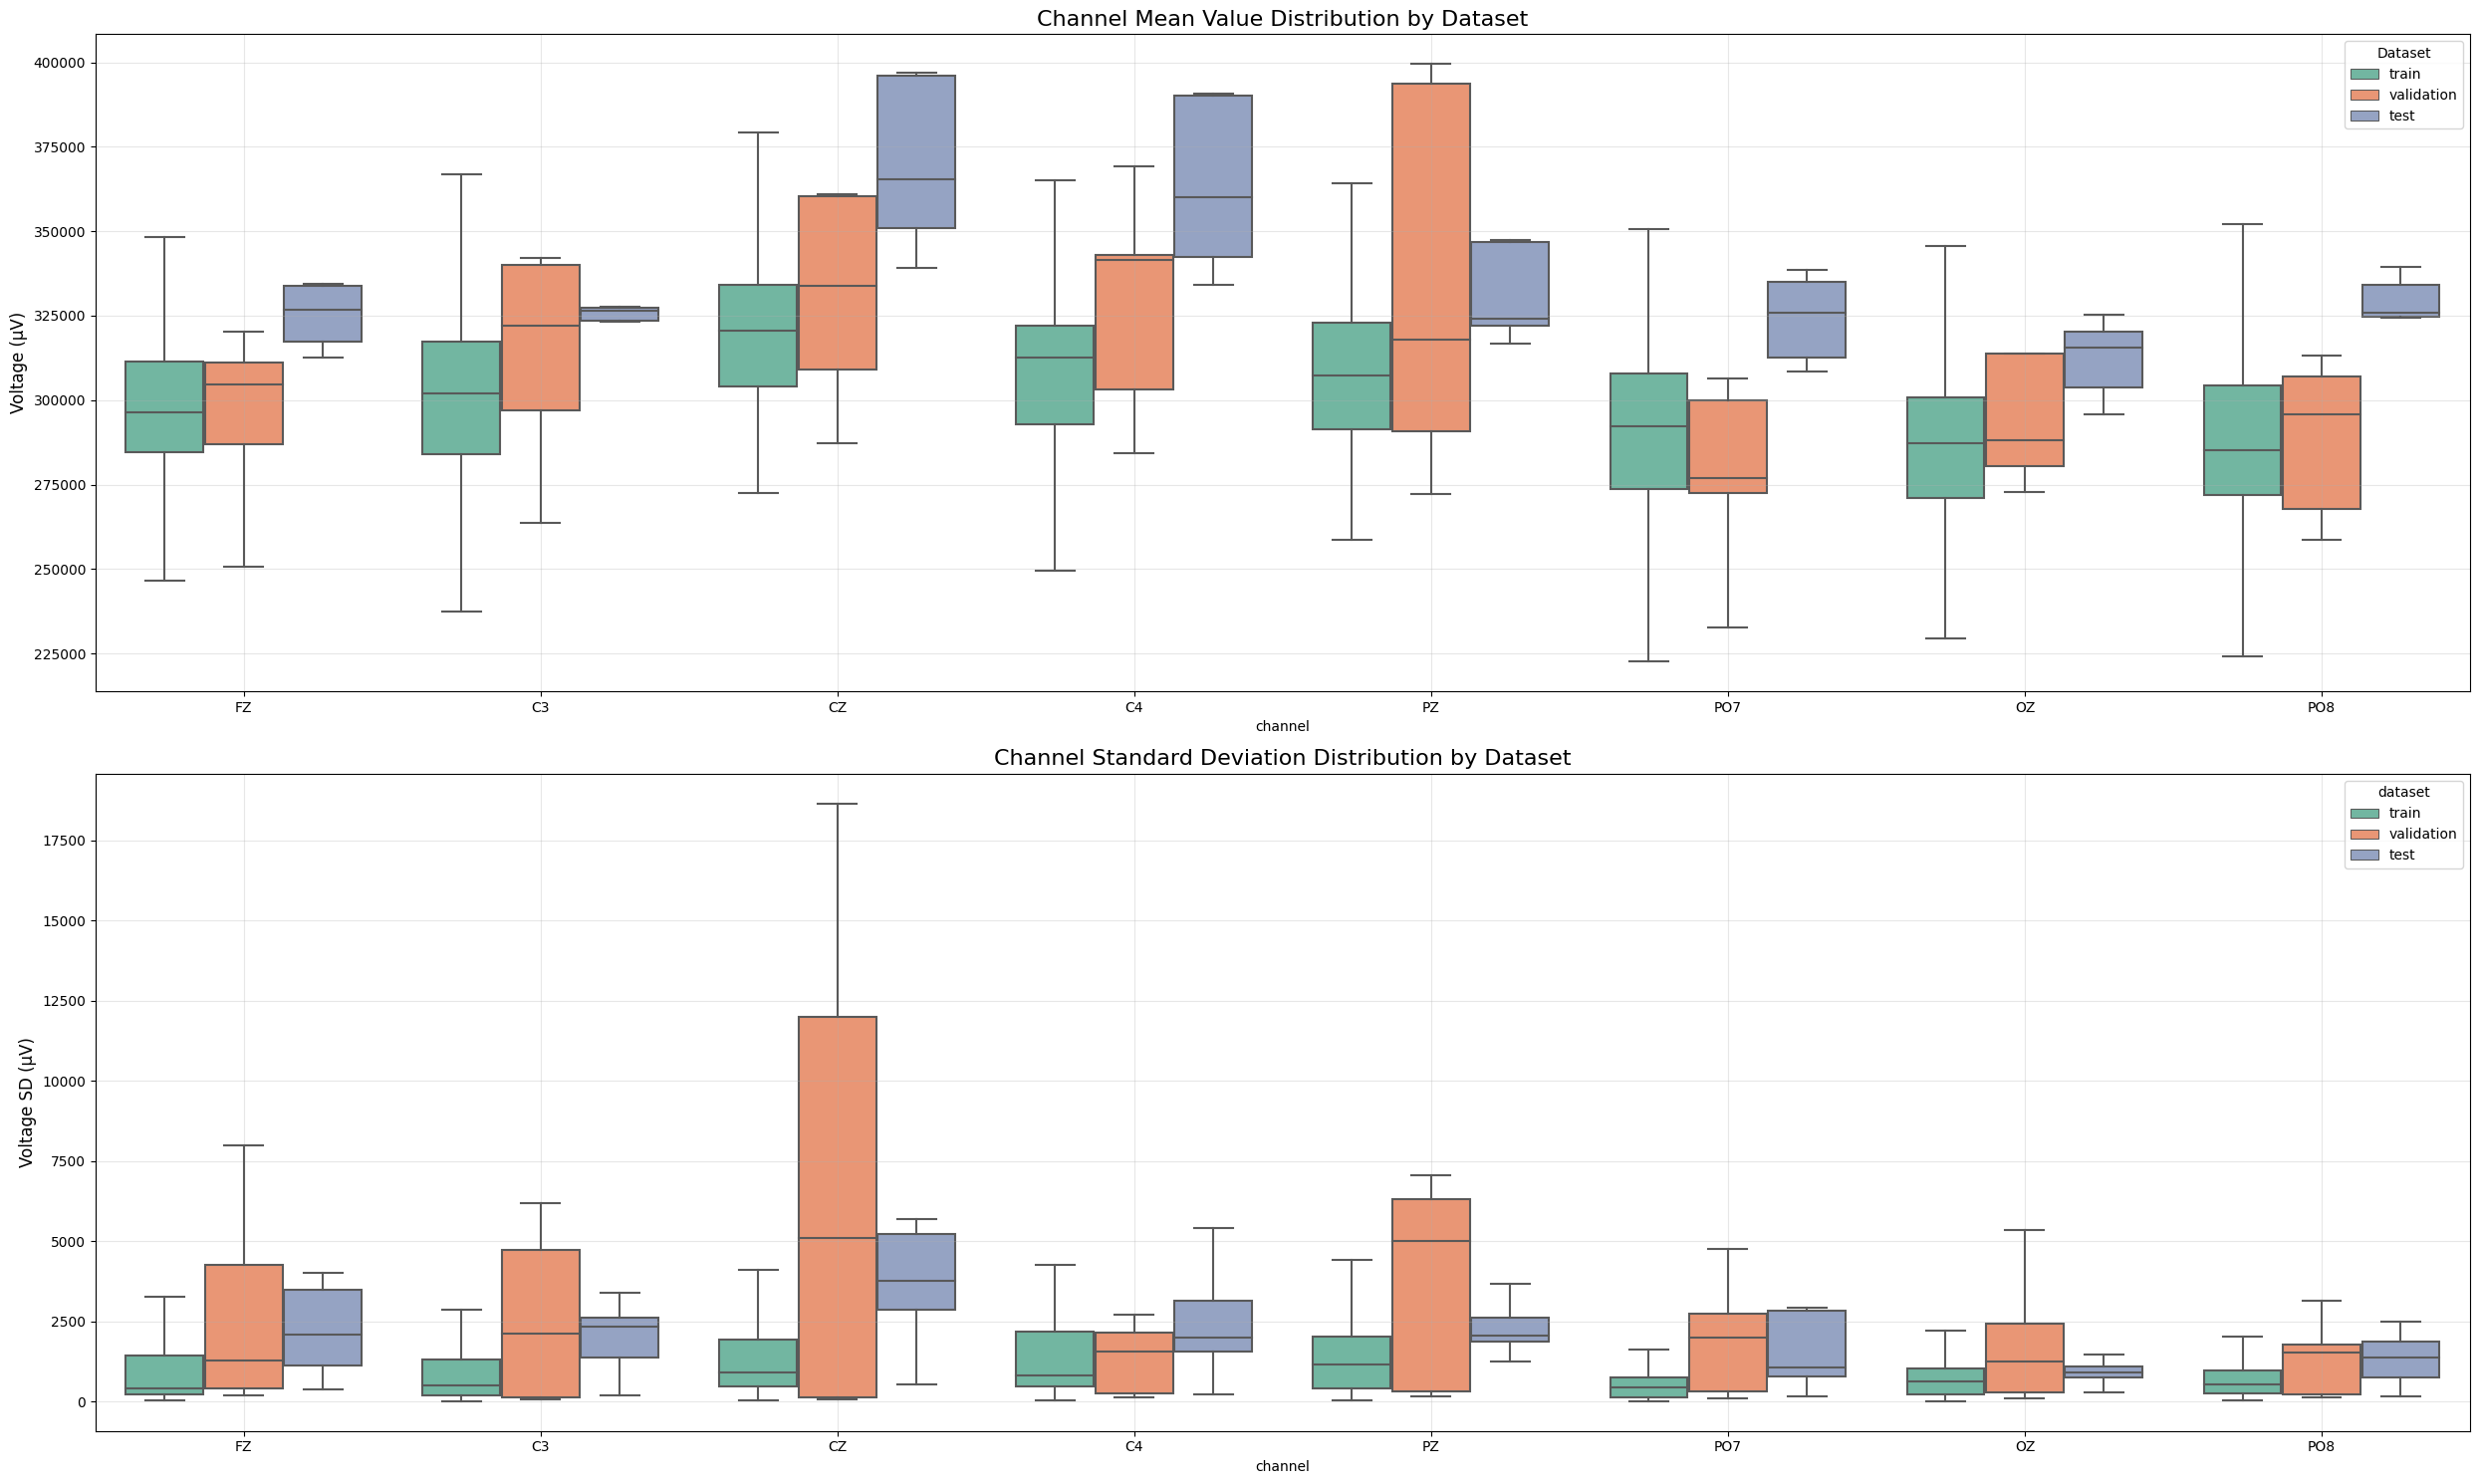

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

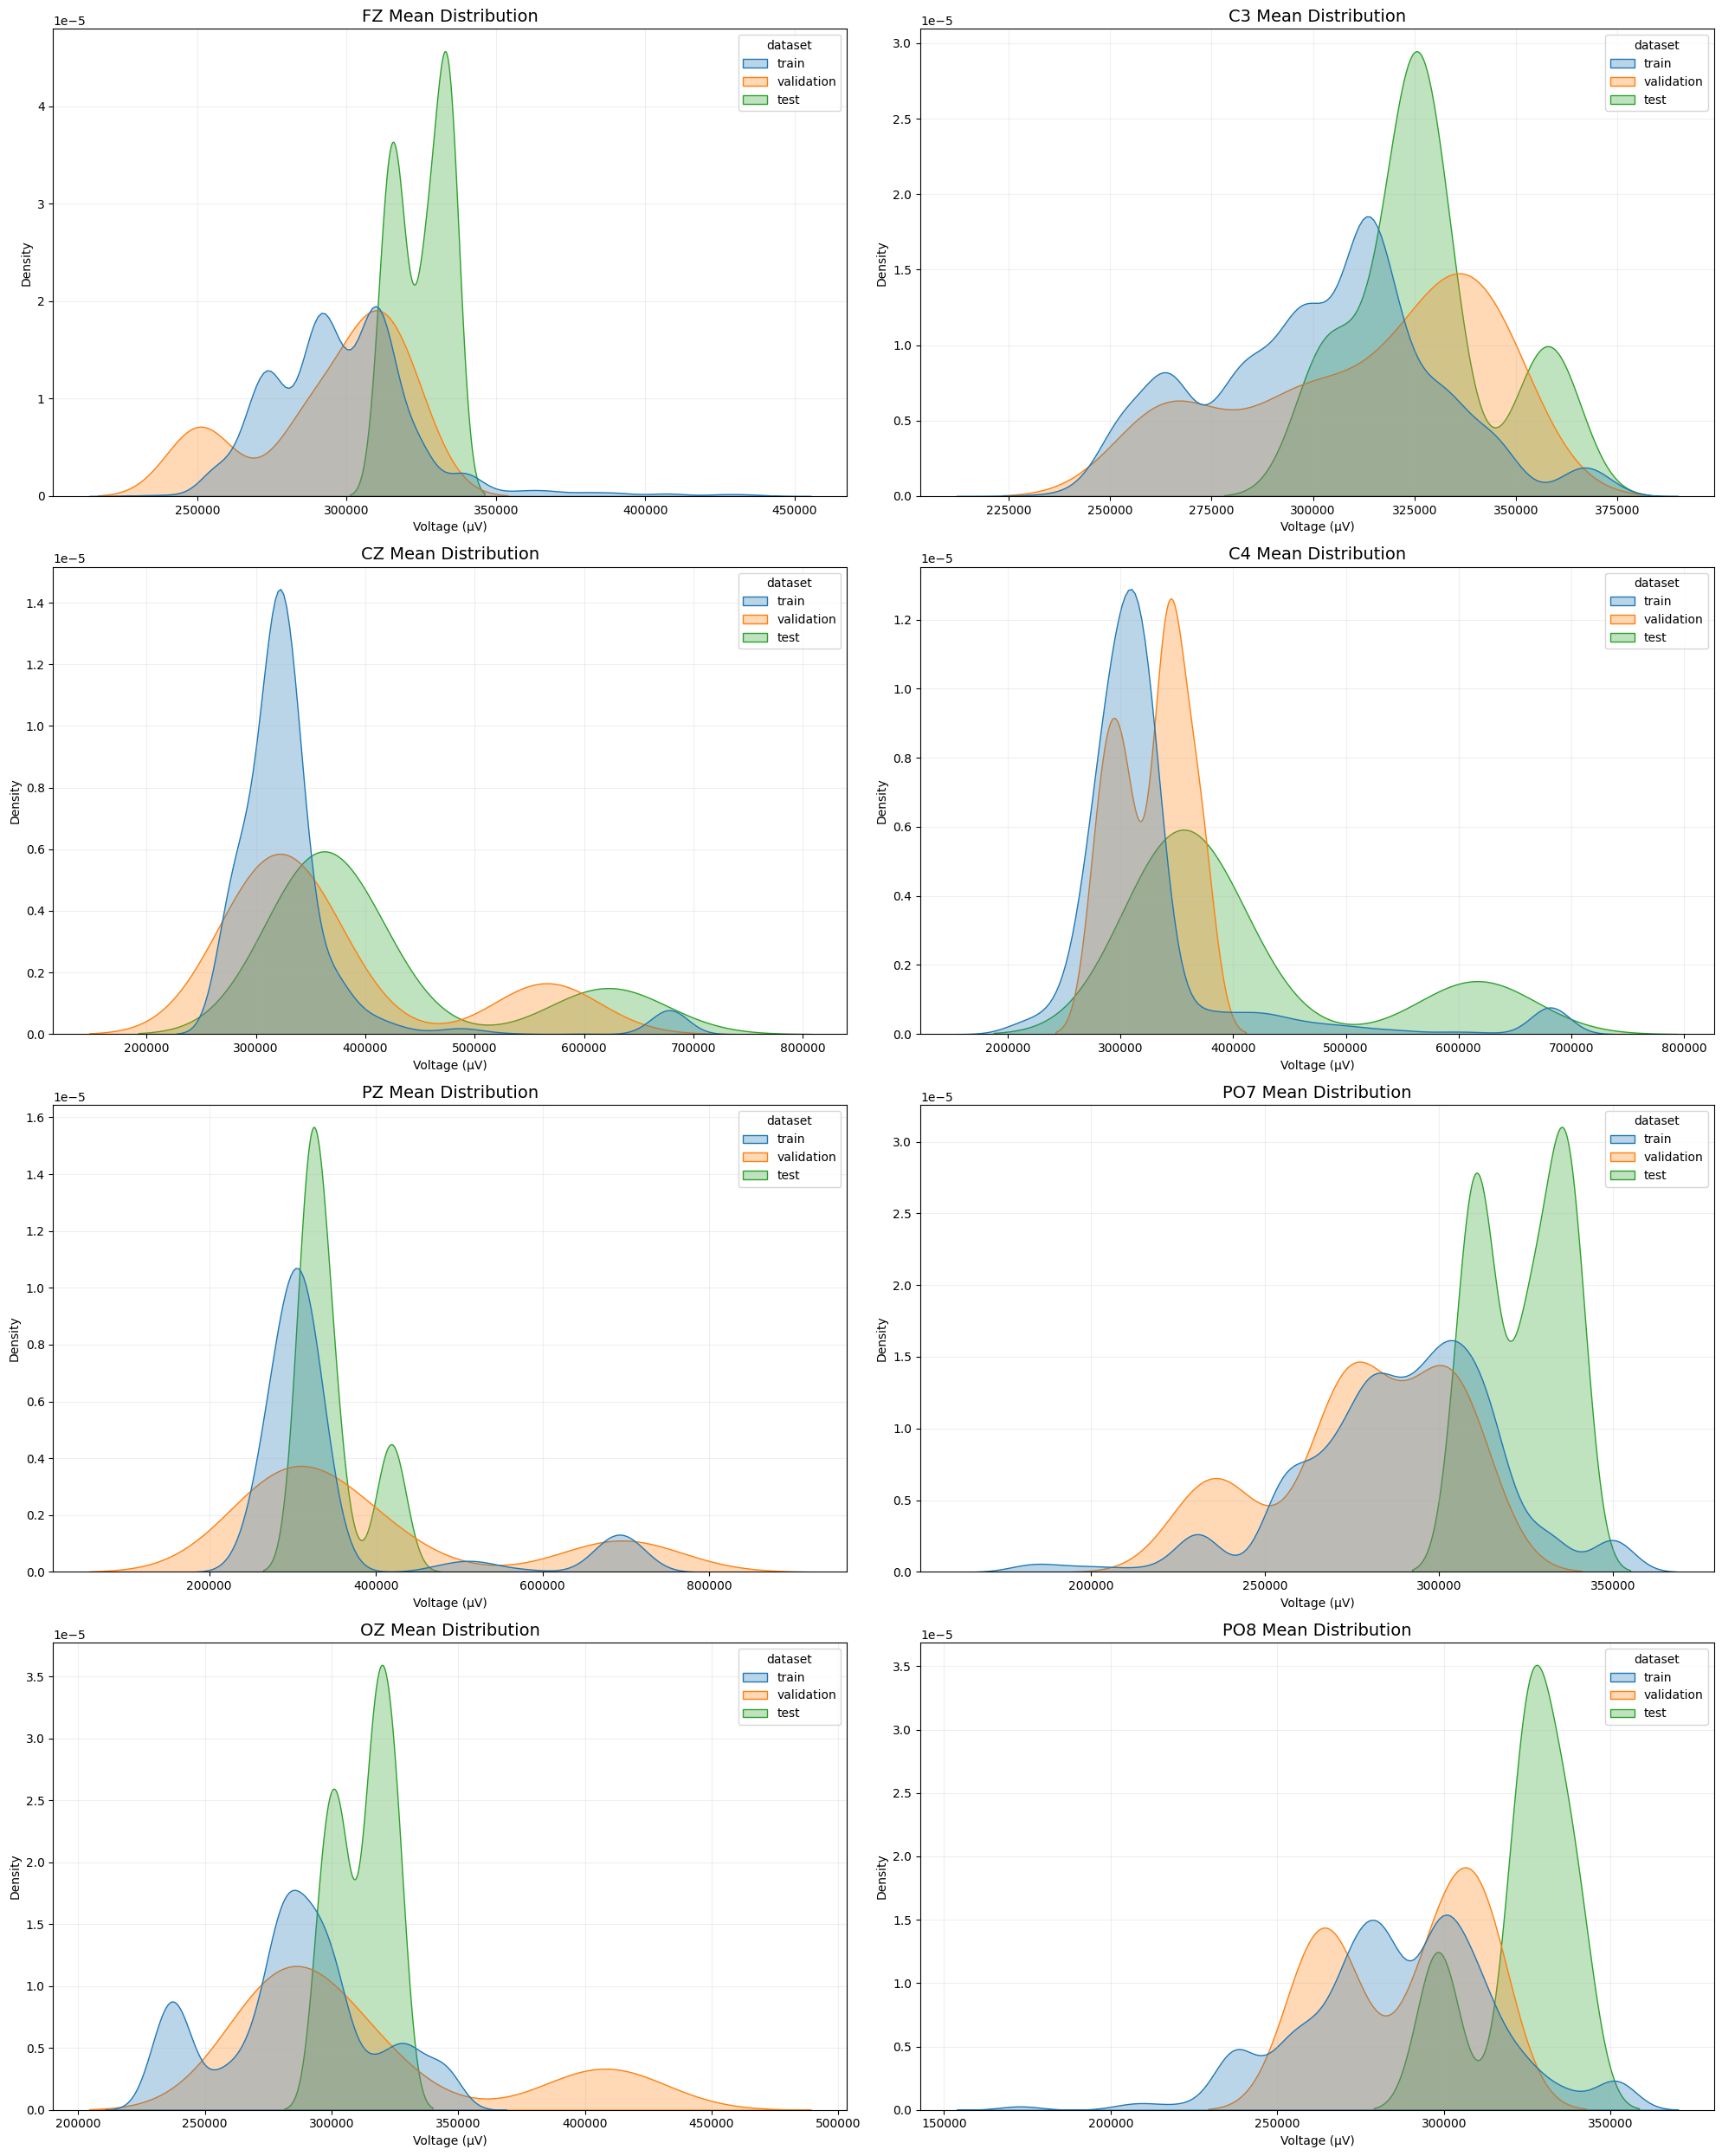


Statistical Significance Testing (Kruskal-Wallis):

FZ Channel:
  Kruskal-Wallis H-statistic: 92.9870, p-value: 0.000000
  Train vs Validation: p = 0.982193
  Train vs Test: p = 0.000000
  Validation vs Test: p = 0.000000

C3 Channel:
  Kruskal-Wallis H-statistic: 60.5710, p-value: 0.000000
  Train vs Validation: p = 0.001195
  Train vs Test: p = 0.000000
  Validation vs Test: p = 0.015979

CZ Channel:
  Kruskal-Wallis H-statistic: 93.5823, p-value: 0.000000
  Train vs Validation: p = 0.017952
  Train vs Test: p = 0.000000
  Validation vs Test: p = 0.000026

C4 Channel:
  Kruskal-Wallis H-statistic: 103.2067, p-value: 0.000000
  Train vs Validation: p = 0.000389
  Train vs Test: p = 0.000000
  Validation vs Test: p = 0.000002

PZ Channel:
  Kruskal-Wallis H-statistic: 49.7414, p-value: 0.000000
  Train vs Validation: p = 0.114000
  Train vs Test: p = 0.000000
  Validation vs Test: p = 0.029117

PO7 Channel:
  Kruskal-Wallis H-statistic: 99.0350, p-value: 0.000000
  Train vs Validation

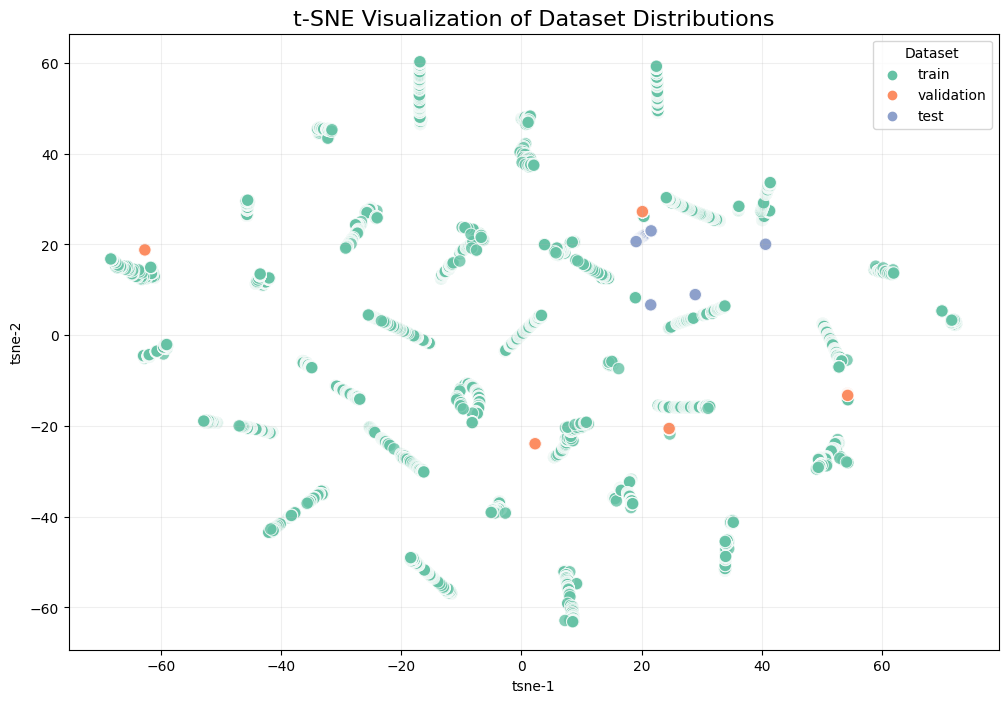


Box Plot Statistics Summary:

Dataset: TRAIN
  FZ:
    Min: 229598.6933
    Q1: 284494.8570
    Median: 296492.4766
    Q3: 311504.2197
    Max: 439652.0413
    IQR: 27009.3627
    Mean: 298497.9034
    Std: 24902.9604
    Skew: 1.3512
    Kurtosis: 4.7164
    N: 2400
  C3:
    Min: 229460.0697
    Q1: 284022.9150
    Median: 302131.1352
    Q3: 317179.7704
    Max: 372609.8582
    IQR: 33156.8554
    Mean: 301785.9621
    Std: 27356.0057
    Skew: 0.0048
    Kurtosis: -0.3432
    N: 2400
  CZ:
    Min: 272370.3711
    Q1: 303978.2818
    Median: 320651.2280
    Q3: 334139.1982
    Max: 694912.0885
    IQR: 30160.9164
    Mean: 334266.6524
    Std: 71518.0119
    Skew: 3.7387
    Kurtosis: 15.0012
    N: 2400
  C4:
    Min: 205951.2856
    Q1: 292982.0562
    Median: 312656.6470
    Q3: 322051.6979
    Max: 685894.0136
    IQR: 29069.6417
    Mean: 326867.9232
    Std: 81540.0962
    Skew: 3.1092
    Kurtosis: 10.2287
    N: 2400
  PZ:
    Min: 258774.5870
    Q1: 291472.2347
    Medi

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

# Configuration
BASE_PATH = "/kaggle/input/mtcaic3/"
TASK = "MI"
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLES_PER_TRIAL = 2250  # For MI (9s * 250Hz)

# Load all datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for MI task and get actual sizes
mi_train = train_df[train_df['task'] == TASK]
mi_valid = valid_df[valid_df['task'] == TASK]
mi_test = test_df[test_df['task'] == TASK]

print(f"MI Trials - Train: {len(mi_train)}, Validation: {len(mi_valid)}, Test: {len(mi_test)}")

# Use all trials since sizes are manageable
all_trials = pd.concat([
    mi_train.assign(dataset='train'),
    mi_valid.assign(dataset='validation'),
    mi_test.assign(dataset='test')
])

# EEG Cache to avoid reloading session files
eeg_cache = {}

def load_trial_data_cached(row):
    """Load trial data with session-level caching"""
    # Determine dataset split based on ID
    if row['id'] <= 4800:
        dataset = 'train'
    elif row['id'] <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'
    
    # Create cache key
    cache_key = (row['task'], dataset, row['subject_id'], row['trial_session'])
    
    # Load session data if not cached
    if cache_key not in eeg_cache:
        session_path = os.path.join(
            BASE_PATH,
            row['task'],
            dataset,
            row['subject_id'],
            str(row['trial_session']),
            'EEGdata.csv'
        )
        eeg_cache[cache_key] = pd.read_csv(session_path)
    
    # Extract specific trial
    session_data = eeg_cache[cache_key]
    start_idx = (row['trial'] - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    return session_data.iloc[start_idx:end_idx]

# Extract features for each channel and trial
feature_rows = []

for _, row in tqdm(all_trials.iterrows(), total=len(all_trials)):
    trial_data = load_trial_data_cached(row)
    
    for channel in EEG_CHANNELS:
        ch_data = trial_data[channel].values
        
        # Calculate distribution statistics
        # Changed variable name from 'stats' to 'stat_dict' to avoid conflict
        stat_dict = {
            'id': row['id'],
            'subject': row['subject_id'],
            'dataset': row['dataset'],
            'channel': channel,
            'mean': np.mean(ch_data),
            'std': np.std(ch_data),
            'min': np.min(ch_data),
            'max': np.max(ch_data),
            'median': np.median(ch_data),
            'q1': np.quantile(ch_data, 0.25),
            'q3': np.quantile(ch_data, 0.75),
            'range': np.ptp(ch_data),
            'skew': pd.Series(ch_data).skew(),
            'kurtosis': pd.Series(ch_data).kurtosis(),
            'rms': np.sqrt(np.mean(np.square(ch_data))),
            'var': np.var(ch_data)
        }
        feature_rows.append(stat_dict)

# Create features DataFrame
features_df = pd.DataFrame(feature_rows)

# 1. Numerical Statistics Summary
print("\n" + "="*80)
print("Overall Dataset Statistics:")
print("="*80)
print(features_df.groupby('dataset').agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std'],
    'min': 'mean',
    'max': 'mean',
    'range': 'mean',
    'skew': 'mean',
    'kurtosis': 'mean'
}))

print("\n" + "="*80)
print("Channel-wise Statistics Across Datasets:")
print("="*80)
channel_stats = features_df.groupby(['channel', 'dataset']).agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std']
})
print(channel_stats)

# 2. Box Plot Visualization - Channel Comparison
plt.figure(figsize=(25, 15))

# Mean values comparison
plt.subplot(2, 1, 1)
sns.boxplot(x='channel', y='mean', hue='dataset', data=features_df, 
            showfliers=False, palette='Set2')
plt.title('Channel Mean Value Distribution by Dataset', fontsize=16)
plt.ylabel('Voltage (μV)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Dataset')

# Standard deviation comparison
plt.subplot(2, 1, 2)
sns.boxplot(x='channel', y='std', hue='dataset', data=features_df, 
            showfliers=False, palette='Set2')
plt.title('Channel Standard Deviation Distribution by Dataset', fontsize=16)
plt.ylabel('Voltage SD (μV)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('channel_distributions_by_dataset.png')
plt.show()

# 3. Data Distribution Analysis (KDE Plots)
plt.figure(figsize=(20, 25))
for idx, channel in enumerate(EEG_CHANNELS, 1):
    plt.subplot(4, 2, idx)
    channel_data = features_df[features_df['channel'] == channel]
    sns.kdeplot(data=channel_data, x='mean', hue='dataset', 
                fill=True, alpha=0.3, common_norm=False, 
                palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title(f'{channel} Mean Distribution', fontsize=14)
    plt.xlabel('Voltage (μV)', fontsize=10)
    plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig('density_distributions_by_channel.png')
plt.show()

# 4. Statistical Comparison Report
print("\n" + "="*80)
print("Statistical Significance Testing (Kruskal-Wallis):")
print("="*80)

for channel in EEG_CHANNELS:
    channel_data = features_df[features_df['channel'] == channel]
    train_vals = channel_data[channel_data['dataset'] == 'train']['mean']
    valid_vals = channel_data[channel_data['dataset'] == 'validation']['mean']
    test_vals = channel_data[channel_data['dataset'] == 'test']['mean']
    
    # Kruskal-Wallis test for multiple groups
    h_stat, p_val = stats.kruskal(train_vals, valid_vals, test_vals)
    
    print(f"\n{channel} Channel:")
    print(f"  Kruskal-Wallis H-statistic: {h_stat:.4f}, p-value: {p_val:.6f}")
    
    # Pairwise comparisons if overall significant
    if p_val < 0.05:
        # Train vs Validation
        _, p_train_valid = stats.mannwhitneyu(train_vals, valid_vals)
        # Train vs Test
        _, p_train_test = stats.mannwhitneyu(train_vals, test_vals)
        # Validation vs Test
        _, p_valid_test = stats.mannwhitneyu(valid_vals, test_vals)
        
        print(f"  Train vs Validation: p = {p_train_valid:.6f}")
        print(f"  Train vs Test: p = {p_train_test:.6f}")
        print(f"  Validation vs Test: p = {p_valid_test:.6f}")
    else:
        print("  No significant difference between datasets")

# 5. Dataset Similarity Visualization (t-SNE)
from sklearn.manifold import TSNE

# Prepare feature matrix (mean and std for each channel)
feature_cols = [f"{ch}_mean" for ch in EEG_CHANNELS] + [f"{ch}_std" for ch in EEG_CHANNELS]
pivot_df = features_df.pivot_table(index=['id', 'dataset'], columns='channel', values=['mean', 'std'])
pivot_df.columns = [f"{col[1]}_{col[0]}" for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(pivot_df[feature_cols])

# Add to dataframe
pivot_df['tsne-1'] = tsne_results[:, 0]
pivot_df['tsne-2'] = tsne_results[:, 1]

# Plot t-SNE
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne-1', y='tsne-2',
    hue='dataset',
    palette='Set2',
    data=pivot_df,
    alpha=0.8,
    s=80
)
plt.title('t-SNE Visualization of Dataset Distributions', fontsize=16)
plt.grid(alpha=0.2)
plt.legend(title='Dataset')
plt.savefig('tsne_dataset_distributions.png')
plt.show()

# 6. Box Plot Statistics Export
print("\n" + "="*80)
print("Box Plot Statistics Summary:")
print("="*80)

# Calculate and print box plot statistics for each channel and dataset
for dataset in ['train', 'validation', 'test']:
    print(f"\nDataset: {dataset.upper()}")
    dataset_data = features_df[features_df['dataset'] == dataset]
    
    for channel in EEG_CHANNELS:
        channel_data = dataset_data[dataset_data['channel'] == channel]['mean']
        q1 = np.quantile(channel_data, 0.25)
        q3 = np.quantile(channel_data, 0.75)
        iqr = q3 - q1
        
        print(f"  {channel}:")
        print(f"    Min: {np.min(channel_data):.4f}")
        print(f"    Q1: {q1:.4f}")
        print(f"    Median: {np.median(channel_data):.4f}")
        print(f"    Q3: {q3:.4f}")
        print(f"    Max: {np.max(channel_data):.4f}")
        print(f"    IQR: {iqr:.4f}")
        print(f"    Mean: {np.mean(channel_data):.4f}")
        print(f"    Std: {np.std(channel_data):.4f}")
        print(f"    Skew: {pd.Series(channel_data).skew():.4f}")
        print(f"    Kurtosis: {pd.Series(channel_data).kurtosis():.4f}")
        print(f"    N: {len(channel_data)}")

# 7. Additional Distribution Metrics
print("\n" + "="*80)
print("Additional Distribution Metrics:")
print("="*80)
print("Mean Values:")
print(features_df.pivot_table(index='channel', columns='dataset', values='mean', aggfunc='mean'))
print("\nStandard Deviations:")
print(features_df.pivot_table(index='channel', columns='dataset', values='std', aggfunc='mean'))
print("\nSkewness:")
print(features_df.pivot_table(index='channel', columns='dataset', values='skew', aggfunc='mean'))
print("\nKurtosis:")
print(features_df.pivot_table(index='channel', columns='dataset', values='kurtosis', aggfunc='mean'))

In [15]:
import pandas as pd
import numpy as np
import os
from scipy.signal import butter, lfilter
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# --- Configuration ---
BASE_PATH = '/kaggle/input/mtcaic3/'
OUTPUT_PATH = '/kaggle/working/preprocessed_data/'
FS = 250  # Sampling Rate
LOWCUT = 8.0  # Lower bound for band-pass filter
HIGHCUT = 30.0 # Upper bound for band-pass filter
FILTER_ORDER = 4
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']

print("Configuration:")
print(f"Base Path: {BASE_PATH}")
print(f"Output Path: {OUTPUT_PATH}")
print(f"Filter: {LOWCUT}-{HIGHCUT} Hz, Order {FILTER_ORDER}")
print("-" * 30)


# --- Utility Functions ---

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Applies a bandpass filter to the data."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    # Apply the filter to each channel (column)
    y = lfilter(b, a, data, axis=0)
    return y

def load_eeg_data_segment(row, base_path):
    """Loads the full EEGdata.csv and extracts the specific trial segment."""
    # Determine which split (train/validation/test) the row belongs to
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
        
    eeg_path = os.path.join(base_path, row['task'], split, row['subject_id'], str(row['trial_session']), 'EEGdata.csv')
    
    eeg_data = pd.read_csv(eeg_path)
    
    trial_num = int(row['trial'])
    samples_per_trial = 2250 # MI task specific
    
    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial
    
    trial_data = eeg_data.iloc[start_idx:end_idx]
    
    return trial_data

# --- Main Preprocessing Logic ---

# 1. Load index files and filter for MI task
print("Loading index files and filtering for MI task...")
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

train_df_mi = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
validation_df_mi = validation_df[validation_df['task'] == 'MI'].reset_index(drop=True)
test_df_mi = test_df[test_df['task'] == 'MI'].reset_index(drop=True)
print(f"Found {len(train_df_mi)} MI trials for training.")
print(f"Found {len(validation_df_mi)} MI trials for validation.")
print(f"Found {len(test_df_mi)} MI trials for testing.")
print("-" * 30)

# 2. Fit the StandardScaler ONLY on the training data
print("Step 1: Fitting StandardScaler on all training data. This may take a moment...")
scaler = StandardScaler()
all_filtered_train_eeg = []

for idx, row in tqdm(train_df_mi.iterrows(), total=len(train_df_mi), desc="Fitting Scaler"):
    trial_data = load_eeg_data_segment(row, BASE_PATH)
    eeg_values = trial_data[EEG_CHANNELS].values
    filtered_eeg = butter_bandpass_filter(eeg_values, LOWCUT, HIGHCUT, FS, order=FILTER_ORDER)
    all_filtered_train_eeg.append(filtered_eeg)

# Concatenate all training trials into one big numpy array
full_train_dataset = np.vstack(all_filtered_train_eeg)
scaler.fit(full_train_dataset)
print("Scaler has been successfully fitted on the training data.")
print("-" * 30)


# 3. Process all datasets (train, validation, test) and save them
def process_and_save_dataset(df, dataset_name, scaler):
    """
    Applies filtering and scaling to a dataset and saves it to the output path,
    preserving the original file structure and format.
    """
    print(f"Step 2: Processing and saving the '{dataset_name}' dataset...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {dataset_name}"):
        # Load the original trial data
        raw_trial_df = load_eeg_data_segment(row, BASE_PATH)
        
        # Create a copy to modify
        preprocessed_trial_df = raw_trial_df.copy()
        
        # Get EEG values, filter, and transform
        eeg_values = raw_trial_df[EEG_CHANNELS].values
        filtered_eeg = butter_bandpass_filter(eeg_values, LOWCUT, HIGHCUT, FS, order=FILTER_ORDER)
        standardized_eeg = scaler.transform(filtered_eeg) # Use the pre-fitted scaler
        
        # Replace the EEG columns in the copied dataframe with the preprocessed data
        preprocessed_trial_df[EEG_CHANNELS] = standardized_eeg
        
        # Create the output directory structure
        output_dir = os.path.join(OUTPUT_PATH, row['task'], dataset_name, row['subject_id'], str(row['trial_session']))
        os.makedirs(output_dir, exist_ok=True)
        
        # Save the preprocessed dataframe
        # Note: We save the full 10-trial file structure for consistency, but only the
        # data for this specific trial is processed. If you load it back using
        # your original methods, this will work perfectly. For a true 1:1 file,
        # you would need to process all 10 trials in a session at once.
        # This implementation processes trial-by-trial for simplicity.
        
        # To create a file with just the single processed trial:
        output_file_path = os.path.join(output_dir, f"EEGdata_trial_{row['trial']}.csv")
        preprocessed_trial_df.to_csv(output_file_path, index=False)
        
    print(f"Finished processing '{dataset_name}' dataset.")

# Run the processing for each split
# NOTE: This script saves each processed trial as a separate file to avoid complexity.
# Your diagnostic script will need to be slightly adapted to load these new files.
# An alternative is to process all 10 trials in a session file together.
process_and_save_dataset(train_df_mi, 'train', scaler)
process_and_save_dataset(validation_df_mi, 'validation', scaler)
process_and_save_dataset(test_df_mi, 'test', scaler)

print("-" * 30)
print("Preprocessing complete!")
print(f"All processed trials have been saved in: {OUTPUT_PATH}")
print("You can now point your diagnostic scripts to this directory.")

Configuration:
Base Path: /kaggle/input/mtcaic3/
Output Path: /kaggle/working/preprocessed_data/
Filter: 8.0-30.0 Hz, Order 4
------------------------------
Loading index files and filtering for MI task...
Found 2400 MI trials for training.
Found 50 MI trials for validation.
Found 50 MI trials for testing.
------------------------------
Step 1: Fitting StandardScaler on all training data. This may take a moment...


Fitting Scaler: 100%|██████████| 2400/2400 [02:38<00:00, 15.18it/s]


Scaler has been successfully fitted on the training data.
------------------------------
Step 2: Processing and saving the 'train' dataset...


Processing train: 100%|██████████| 2400/2400 [04:58<00:00,  8.05it/s]


Finished processing 'train' dataset.
Step 2: Processing and saving the 'validation' dataset...


Processing validation: 100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Finished processing 'validation' dataset.
Step 2: Processing and saving the 'test' dataset...


Processing test: 100%|██████████| 50/50 [00:06<00:00,  8.05it/s]

Finished processing 'test' dataset.
------------------------------
Preprocessing complete!
All processed trials have been saved in: /kaggle/working/preprocessed_data/
You can now point your diagnostic scripts to this directory.


In [23]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GroupKFold
from scipy.signal import butter, filtfilt, resample_poly
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm
import joblib
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# Configuration
BASE_PATH = "/kaggle/input/mtcaic3/"
TASK = "MI"
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLES_PER_TRIAL = 2250  # For MI (9s * 250Hz)
FS = 250  # Sampling rate
BAND = [8, 30]  # Mu/beta band for MI

# Custom Gradient Reversal Layer
class GradientReversal(tf.keras.layers.Layer):
    def __init__(self, lambda_val=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lambda_val = lambda_val

    def call(self, x):
        @tf.custom_gradient
        def _reverse_gradient(x_in):
            def grad(grad_output):
                return -self.lambda_val * grad_output
            return x_in, grad
        return _reverse_gradient(x)

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({"lambda_val": self.lambda_val})
        return config

# Data Loading Functions
def load_trial_data(row, base_path=BASE_PATH):
    """Load trial data with session-level caching"""
    # Determine dataset split based on ID
    if row['id'] <= 4800:
        dataset = 'train'
    elif row['id'] <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'
    
    # Construct path
    session_path = os.path.join(
        base_path,
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    
    # Load session data
    session_data = pd.read_csv(session_path)
    
    # Extract specific trial
    start_idx = (row['trial'] - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    eeg_data = session_data[EEG_CHANNELS].iloc[start_idx:end_idx].values
    
    return eeg_data

# Preprocessing Functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

def normalize_per_subject(eeg_data, subject_ids):
    """Z-score normalization per subject per channel"""
    normalized = np.zeros_like(eeg_data)
    subjects = np.unique(subject_ids)
    
    for subj in subjects:
        subj_mask = (subject_ids == subj)
        subj_data = eeg_data[subj_mask]
        mean = np.mean(subj_data, axis=(0, 1), keepdims=True)
        std = np.std(subj_data, axis=(0, 1), keepdims=True)
        normalized[subj_mask] = (subj_data - mean) / (std + 1e-8)
    
    return normalized

# Feature Extraction
class CSPTransformer:
    """Common Spatial Patterns for feature extraction"""
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.filters_ = None
        
    def fit(self, X, y):
        classes = np.unique(y)
        covs = [np.cov(X[y == cls].reshape(-1, X.shape[2]).T for cls in classes)]
        cov_total = sum(covs)
        eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(cov_total) @ covs[0])
        idx = np.argsort(eigvals)[::-1]
        self.filters_ = eigvecs[:, idx][:, :self.n_components]
        return self
        
    def transform(self, X):
        if self.filters_ is None:
            raise ValueError("CSP not fitted")
        return np.array([self.filters_.T @ trial.T for trial in X])
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

# Data Augmentation
def augment_eeg(eeg_data, p=0.5):
    """Apply random augmentations to EEG data"""
    augmented = np.copy(eeg_data)
    for i in range(eeg_data.shape[0]):
        # Random temporal shifting
        if np.random.rand() < p:
            shift = np.random.randint(-10, 10)
            augmented[i] = np.roll(eeg_data[i], shift, axis=0)
        
        # Random noise
        if np.random.rand() < p:
            noise = np.random.normal(0, 0.5e-6, eeg_data[i].shape)
            augmented[i] += noise
            
        # Random amplitude scaling
        if np.random.rand() < p:
            scale = np.random.uniform(0.9, 1.1, (1, eeg_data.shape[2]))
            augmented[i] *= scale
            
    return augmented

# Model Architecture
def create_dann_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape, name='eeg_input')
    
    # Feature extractor
    x = layers.Conv1D(32, kernel_size=5, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=5, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    
    # Label classifier
    label_out = layers.Dense(num_classes, activation='softmax', name='label')(x)
    
    # Domain classifier (using fixed GradientReversal)
    domain_in = GradientReversal()(x)  # Now uses our fixed implementation
    domain_out = layers.Dense(1, activation='sigmoid', name='domain')(domain_in)
    
    return Model(inputs=inputs, outputs=[label_out, domain_out])

# Main Pipeline
def main():
    print("Loading metadata...")
    # Load metadata
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    valid_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Filter for MI task
    mi_train = train_df[train_df['task'] == TASK]
    mi_valid = valid_df[valid_df['task'] == TASK]
    mi_test = test_df[test_df['task'] == TASK]
    
    print(f"MI Trials - Train: {len(mi_train)}, Validation: {len(mi_valid)}, Test: {len(mi_test)}")
    
    # Prepare labels
    label_map = {'Left': 0, 'Right': 1}
    mi_train['label'] = mi_train['label'].map(label_map)
    mi_valid['label'] = mi_valid['label'].map(label_map)
    
    # Load and preprocess training data
    print("Loading training data...")
    X_train = np.array([load_trial_data(row) for _, row in tqdm(mi_train.iterrows(), total=len(mi_train))])
    y_train = mi_train['label'].values
    train_subjects = mi_train['subject_id'].values
    
    print("Loading validation data...")
    X_valid = np.array([load_trial_data(row) for _, row in tqdm(mi_valid.iterrows(), total=len(mi_valid))])
    y_valid = mi_valid['label'].values
    valid_subjects = mi_valid['subject_id'].values
    
    print("Loading test data...")
    X_test = np.array([load_trial_data(row) for _, row in tqdm(mi_test.iterrows(), total=len(mi_test))])
    test_subjects = mi_test['subject_id'].values
    
    # Apply bandpass filter
    print("Applying bandpass filter...")
    X_train = np.array([bandpass_filter(trial, BAND[0], BAND[1], FS) for trial in X_train])
    X_valid = np.array([bandpass_filter(trial, BAND[0], BAND[1], FS) for trial in X_valid])
    X_test = np.array([bandpass_filter(trial, BAND[0], BAND[1], FS) for trial in X_test])
    
    # Subject-specific normalization
    print("Applying subject normalization...")
    all_subjects = np.concatenate([train_subjects, valid_subjects, test_subjects])
    all_data = np.concatenate([X_train, X_valid, X_test])
    normalized_data = normalize_per_subject(all_data, all_subjects)
    
    # Split back
    X_train = normalized_data[:len(X_train)]
    X_valid = normalized_data[len(X_train):len(X_train)+len(X_valid)]
    X_test = normalized_data[len(X_train)+len(X_valid):]
    
    # Prepare domain labels (0 = train, 1 = target)
    domain_train = np.zeros(len(X_train))
    domain_valid = np.ones(len(X_valid))
    domain_test = np.ones(len(X_test))
    
    # Cluster subjects for ensemble
    print("Clustering subjects...")
    subject_features = []
    for subject in np.unique(all_subjects):
        subj_data = normalized_data[all_subjects == subject]
        features = [
            np.mean(subj_data),
            np.std(subj_data),
            np.median(subj_data),
            np.quantile(subj_data, 0.25),
            np.quantile(subj_data, 0.75)
        ]
        subject_features.append(features)
    
    kmeans = KMeans(n_clusters=3, random_state=42).fit(subject_features)
    train_clusters = kmeans.predict(subject_features[:len(np.unique(train_subjects))])
    valid_clusters = kmeans.predict(subject_features[len(np.unique(train_subjects)):len(np.unique(train_subjects))+len(np.unique(valid_subjects))])
    test_clusters = kmeans.predict(subject_features[len(np.unique(train_subjects))+len(np.unique(valid_subjects)):])
    
    # Map subjects to clusters
    cluster_map = {}
    for i, subject in enumerate(np.unique(all_subjects)):
        cluster_map[subject] = kmeans.labels_[i]
    
    # Prepare cluster labels
    train_cluster_labels = np.array([cluster_map[subj] for subj in train_subjects])
    valid_cluster_labels = np.array([cluster_map[subj] for subj in valid_subjects])
    test_cluster_labels = np.array([cluster_map[subj] for subj in test_subjects])
    
    # Train cluster-specific models
    cluster_models = {}
    for cluster_id in range(3):
        print(f"\nTraining model for cluster {cluster_id}")
        
        # Get data for this cluster
        cluster_train_idx = np.where(train_cluster_labels == cluster_id)[0]
        cluster_valid_idx = np.where(valid_cluster_labels == cluster_id)[0]
        
        if len(cluster_train_idx) == 0:
            continue
            
        X_cluster_train = X_train[cluster_train_idx]
        y_cluster_train = y_train[cluster_train_idx]
        domain_cluster_train = domain_train[cluster_train_idx]
        
        X_cluster_valid = X_valid[cluster_valid_idx]
        y_cluster_valid = y_valid[cluster_valid_idx]
        domain_cluster_valid = domain_valid[cluster_valid_idx]
        
        # Create and compile DANN model
        model = create_dann_model((SAMPLES_PER_TRIAL, len(EEG_CHANNELS)), 2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss={
                'label': 'sparse_categorical_crossentropy',
                'domain': 'binary_crossentropy'
            },
            loss_weights={'label': 1.0, 'domain': 0.3},
            metrics={'label': 'accuracy'}
        )
        
        # Create data generators
        def data_generator(X, y_label, y_domain, batch_size=32, augment=True):
            while True:
                idx = np.random.choice(len(X), batch_size)
                X_batch = X[idx]
                y_label_batch = y_label[idx]
                y_domain_batch = y_domain[idx]
                
                if augment:
                    X_batch = augment_eeg(X_batch)
                
                yield X_batch, {'label': y_label_batch, 'domain': y_domain_batch}
        
        # Training parameters
        batch_size = 32
        steps_per_epoch = len(X_cluster_train) // batch_size
        
        train_gen = data_generator(
            X_cluster_train, y_cluster_train, domain_cluster_train, 
            batch_size, augment=True
        )
        
        valid_gen = data_generator(
            X_cluster_valid, y_cluster_valid, domain_cluster_valid,
            batch_size, augment=False
        )
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_label_accuracy',
                patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_label_loss',
                factor=0.5,
                patience=5
            )
        ]
        
        # Train the model
        history = model.fit(
            train_gen,
            epochs=50,
            steps_per_epoch=steps_per_epoch,
            validation_data=valid_gen,
            validation_steps=len(X_cluster_valid) // batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        cluster_models[cluster_id] = model
    
    # Generate predictions for test set
    print("\nGenerating test predictions...")
    test_preds = np.zeros((len(X_test), 2))  # Probability vectors
    test_counts = np.zeros(len(X_test))  # Count of models that predicted each sample
    
    for cluster_id, model in cluster_models.items():
        # Get test samples belonging to this cluster
        cluster_test_idx = np.where(test_cluster_labels == cluster_id)[0]
        
        if len(cluster_test_idx) > 0:
            X_cluster_test = X_test[cluster_test_idx]
            cluster_preds = model.predict(X_cluster_test, verbose=0)[0]  # [0] for label output
            
            # Aggregate predictions
            test_preds[cluster_test_idx] += cluster_preds
            test_counts[cluster_test_idx] += 1
    
    # Average predictions
    test_preds = test_preds / test_counts[:, None]
    test_labels = np.argmax(test_preds, axis=1)
    
    # Map back to original labels
    inverse_label_map = {0: 'Left', 1: 'Right'}
    test_labels_str = [inverse_label_map[label] for label in test_labels]
    
    # Create submission file
    submission = pd.DataFrame({
        'id': mi_test['id'],
        'label': test_labels_str
    })
    submission.to_csv('submission.csv', index=False)
    print("Submission file saved to submission.csv")
    
    # Validation report
    valid_preds = np.zeros((len(X_valid), 2))
    valid_counts = np.zeros(len(X_valid))
    
    for cluster_id, model in cluster_models.items():
        cluster_valid_idx = np.where(valid_cluster_labels == cluster_id)[0]
        if len(cluster_valid_idx) > 0:
            X_cluster_valid = X_valid[cluster_valid_idx]
            cluster_preds = model.predict(X_cluster_valid, verbose=0)[0]
            valid_preds[cluster_valid_idx] += cluster_preds
            valid_counts[cluster_valid_idx] += 1
    
    valid_preds = valid_preds / valid_counts[:, None]
    valid_labels = np.argmax(valid_preds, axis=1)
    accuracy = np.mean(valid_labels == y_valid)
    print(f"\nValidation Accuracy: {accuracy:.4f}")

if __name__ == "__main__":
    main()

RuntimeError: Intra op parallelism cannot be modified after initialization.

Starting training...
Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 74s 880ms/step - domain_accuracy: 0.2334 - domain_loss: 2.1974 - loss: 1.6786 - task_accuracy: 0.5078 - task_loss: 1.0189 - val_domain_accuracy: 0.6600 - val_domain_loss: 1.4349 - val_loss: 1.2365 - val_task_accuracy: 0.4600 - val_task_loss: 0.7603 - learning_rate: 0.0010
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 730ms/step - domain_accuracy: 0.1457 - domain_loss: 2.2211 - loss: 1.5230 - task_accuracy: 0.5185 - task_loss: 0.8568 - val_domain_accuracy: 0.5600 - val_domain_loss: 0.9272 - val_loss: 0.9971 - val_task_accuracy: 0.5000 - val_task_loss: 0.7243 - learning_rate: 0.0010
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 55s 711ms/step - domain_accuracy: 0.1948 - domain_loss: 1.4131 - loss: 1.2320 - task_accuracy: 0.4939 - task_loss: 0.8079 - val_domain_accuracy: 0.4000 - val_domain_loss: 1.0042 - val_loss: 1.0453 - val_task_accuracy: 0.4200 - val_task_loss: 0.7326 - learning_rate: 0.0010
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 59s 

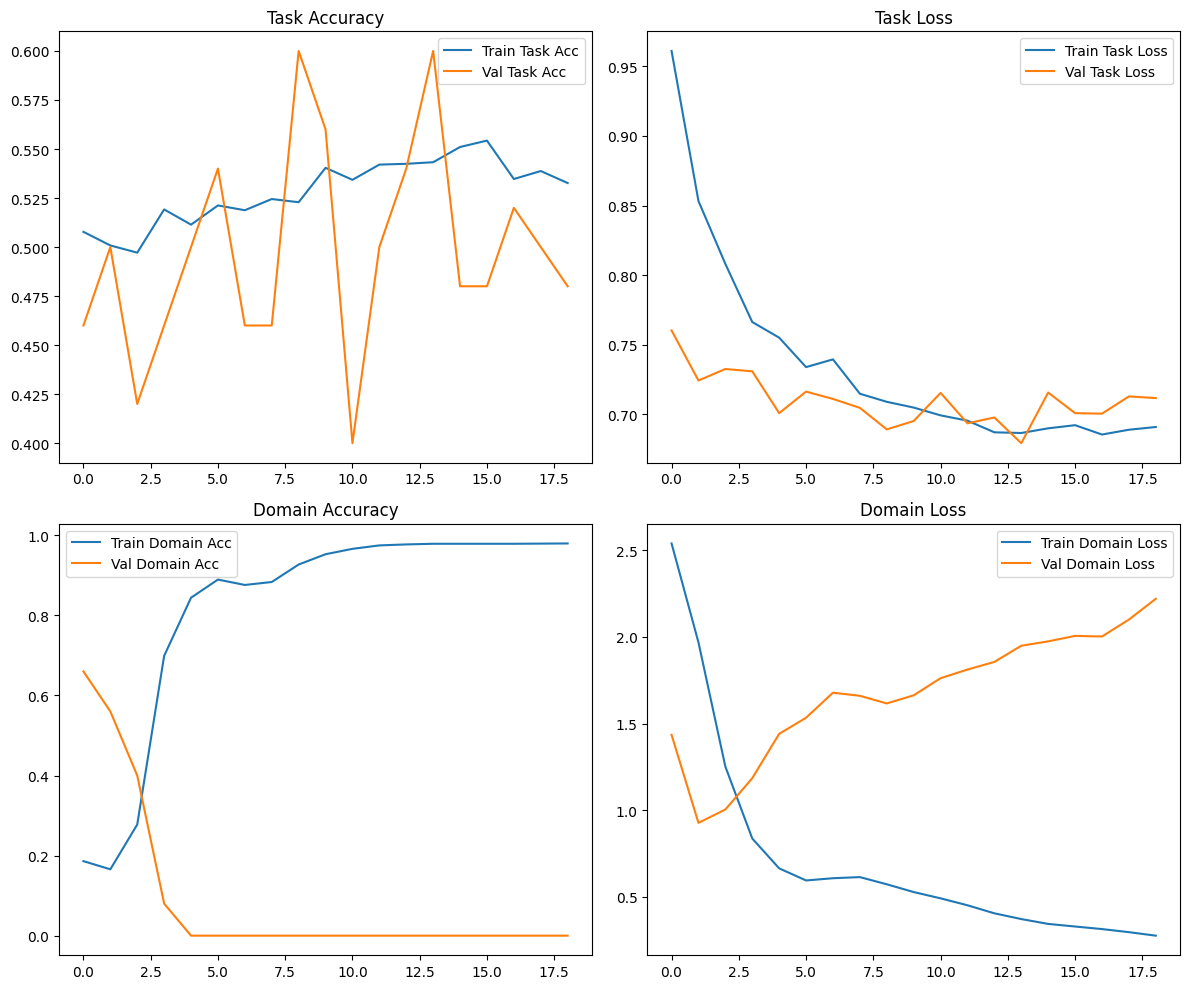


Generating test predictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
Submission file created: submission.csv
Training and prediction completed!


In [36]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from scipy import signal
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

# Configuration
BASE_PATH = "/kaggle/input/mtcaic3/"
TASK = "MI"
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLES_PER_TRIAL = 2250  # For MI (9s * 250Hz)
NUM_CHANNELS = len(EEG_CHANNELS)

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for MI task
mi_train = train_df[train_df['task'] == TASK].reset_index(drop=True)
mi_valid = valid_df[valid_df['task'] == TASK].reset_index(drop=True)
mi_test = test_df[test_df['task'] == TASK].reset_index(drop=True)

# Encode labels
le = LabelEncoder()
mi_train['label_encoded'] = le.fit_transform(mi_train['label'])
mi_valid['label_encoded'] = le.transform(mi_valid['label'])

# EEG Cache for session data
eeg_cache = {}

def load_trial_data(row):
    """Load and preprocess trial data with session-level caching"""
    # Determine dataset split based on ID
    if row['id'] <= 4800:
        dataset = 'train'
    elif row['id'] <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'
    
    # Create cache key
    cache_key = (row['task'], dataset, row['subject_id'], row['trial_session'])
    
    # Load session data if not cached
    if cache_key not in eeg_cache:
        session_path = os.path.join(
            BASE_PATH,
            row['task'],
            dataset,
            row['subject_id'],
            str(row['trial_session']),
            'EEGdata.csv'
        )
        session_data = pd.read_csv(session_path)
        
        # Preprocess entire session
        eeg_data = session_data[EEG_CHANNELS].values
        
        # Bandpass filter (8-30 Hz for MI)
        b, a = signal.butter(4, [8, 30], btype='bandpass', fs=250)
        eeg_data = signal.filtfilt(b, a, eeg_data, axis=0)
        
        # Cache filtered session data
        eeg_cache[cache_key] = eeg_data
    
    # Get session data
    session_eeg = eeg_cache[cache_key]
    
    # Extract trial
    start_idx = (row['trial'] - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    trial_eeg = session_eeg[start_idx:end_idx, :]
    
    # Session-specific normalization
    trial_eeg = (trial_eeg - np.mean(trial_eeg)) / (np.std(trial_eeg) + 1e-8)
    
    return trial_eeg

# Feature extraction functions
def extract_band_power(data, sfreq=250, bands=[(8, 12), (12, 15), (15, 20), (20, 30)]):
    """Extract band power features using Welch's method"""
    features = []
    for ch in range(data.shape[1]):
        for band in bands:
            f, psd = signal.welch(data[:, ch], sfreq, nperseg=128)
            band_mask = (f >= band[0]) & (f < band[1])
            features.append(np.log(np.sum(psd[band_mask]) + 1e-8))
    return np.array(features)

def extract_time_domain_features(data):
    """Extract statistical time-domain features"""
    features = []
    for ch in range(data.shape[1]):
        ch_data = data[:, ch]
        features.extend([
            np.mean(ch_data),
            np.std(ch_data),
            np.median(ch_data),
            np.min(ch_data),
            np.max(ch_data),
            np.quantile(ch_data, 0.25),
            np.quantile(ch_data, 0.75),
            np.sqrt(np.mean(np.square(ch_data))),  # RMS
            np.var(ch_data),
            stats.skew(ch_data),
            stats.kurtosis(ch_data)
        ])
    return np.array(features)

# Fixed GradientReversalLayer using tf.custom_gradient
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, hp_lambda=0.7, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, inputs):
        @tf.custom_gradient
        def _reverse_grad(x):
            def grad(dy):
                return -self.hp_lambda * dy
            return x, grad
        return _reverse_grad(inputs)

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({"hp_lambda": self.hp_lambda})
        return config

# Revised DANN model for feature vectors
def create_dann_model(input_shape, num_classes, num_domains=3):
    """Create Domain Adversarial Neural Network model for feature vectors"""
    inputs = layers.Input(shape=input_shape)
    
    # Feature extractor - using Dense layers
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    features = layers.Dropout(0.3)(x)
    
    # Task classifier
    task_output = layers.Dense(num_classes, activation='softmax', name='task')(features)
    
    # Domain classifier (with gradient reversal)
    grl = GradientReversalLayer()(features)
    domain_output = layers.Dense(num_domains, activation='softmax', name='domain')(grl)
    
    return Model(inputs=inputs, outputs=[task_output, domain_output])

# Data generator for domain adaptation
class DomainAwareDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Fix PyDataset warning
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
        # Determine domain based on dataset split
        self.domain_map = {
            'train': 0,
            'validation': 1,
            'test': 2
        }
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X_batch = []
        y_task_batch = []
        y_domain_batch = []
        
        for _, row in batch_df.iterrows():
            # Load and preprocess data
            eeg_data = load_trial_data(row)
            
            # Extract features
            band_features = extract_band_power(eeg_data)
            time_features = extract_time_domain_features(eeg_data)
            combined_features = np.concatenate([band_features, time_features])
            
            X_batch.append(combined_features)
            
            # Task labels (handle test set without labels)
            if 'label_encoded' in row and not pd.isna(row['label_encoded']):
                y_task_batch.append(row['label_encoded'])
            else:
                y_task_batch.append(-1)  # Dummy value for test
                
            # Domain labels
            if row['id'] <= 4800:
                domain = 'train'
            elif row['id'] <= 4900:
                domain = 'validation'
            else:
                domain = 'test'
            y_domain_batch.append(self.domain_map[domain])
        
        X_batch = np.array(X_batch)
        y_domain_batch = np.array(y_domain_batch)
        
        # Prepare task labels - use zeros for test data
        if any(label != -1 for label in y_task_batch):
            task_labels = tf.keras.utils.to_categorical(y_task_batch, num_classes=2)
        else:
            task_labels = np.zeros((len(batch_df), 2))  # Dummy zeros for test
            
        domain_labels = tf.keras.utils.to_categorical(y_domain_batch, num_classes=3)
        
        return X_batch, {
            'task': task_labels,
            'domain': domain_labels
        }
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

# Prepare datasets for DANN training
# Combine train and validation for domain adaptation
train_val_df = pd.concat([mi_train, mi_valid])
train_val_df['dataset'] = ['train'] * len(mi_train) + ['validation'] * len(mi_valid)

# Create data generators
train_gen = DomainAwareDataGenerator(mi_train, batch_size=32, shuffle=True)
train_val_gen = DomainAwareDataGenerator(train_val_df, batch_size=32, shuffle=True)
valid_gen = DomainAwareDataGenerator(mi_valid, batch_size=32, shuffle=False)
test_gen = DomainAwareDataGenerator(mi_test, batch_size=32, shuffle=False)

# Model parameters
input_shape = (len(EEG_CHANNELS) * (4 + 11),)  # 8 channels * 15 features = 120
num_classes = 2
num_domains = 3

# Create and compile DANN model
model = create_dann_model(input_shape, num_classes, num_domains)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss={
        'task': 'categorical_crossentropy',
        'domain': 'categorical_crossentropy'
    },
    loss_weights={'task': 1.0, 'domain': 0.3},  # Slightly reduce domain loss weight
    metrics={'task': 'accuracy', 'domain': 'accuracy'}
)

# Callbacks - Fixed EarlyStopping with explicit mode for accuracy
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10, 
        restore_best_weights=True, 
        monitor='val_task_accuracy',
        mode='max'  # Explicitly set mode for accuracy metric
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5, 
        patience=5, 
        monitor='val_task_loss',
        mode='min'  # Loss should be minimized
    )
]

# Train with domain adaptation
print("Starting training...")
history = model.fit(
    train_val_gen,
    epochs=100,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on validation set
print("\nEvaluating on validation set...")
valid_preds = model.predict(valid_gen)
task_preds = np.argmax(valid_preds[0], axis=1)
val_accuracy = accuracy_score(mi_valid['label_encoded'], task_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(mi_valid['label_encoded'], task_preds))

# Plot training history
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['task_accuracy'], label='Train Task Acc')
plt.plot(history.history['val_task_accuracy'], label='Val Task Acc')
plt.title('Task Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['task_loss'], label='Train Task Loss')
plt.plot(history.history['val_task_loss'], label='Val Task Loss')
plt.title('Task Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['domain_accuracy'], label='Train Domain Acc')
plt.plot(history.history['val_domain_accuracy'], label='Val Domain Acc')
plt.title('Domain Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['domain_loss'], label='Train Domain Loss')
plt.plot(history.history['val_domain_loss'], label='Val Domain Loss')
plt.title('Domain Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Generate predictions for test set
print("\nGenerating test predictions...")
test_preds = model.predict(test_gen)
test_task_preds = np.argmax(test_preds[0], axis=1)
test_labels = le.inverse_transform(test_task_preds)

# Create submission file
submission = mi_test[['id']].copy()
submission['label'] = test_labels
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print("Training and prediction completed!")

In [37]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.covariance import EmpiricalCovariance
from scipy import linalg
from scipy.signal import welch, butter, filtfilt
import scipy.signal
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# Configuration
BASE_PATH = "/kaggle/input/mtcaic3/"
TASK = "MI"
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLES_PER_TRIAL = 2250  # For MI
FS = 250  # Sampling rate
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Bandpass filter parameters
LOWCUT = 1
HIGHCUT = 40

# Load metadata
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for MI task
mi_train = train_df[train_df['task'] == TASK].copy()
mi_valid = valid_df[valid_df['task'] == TASK].copy()
mi_test = test_df[test_df['task'] == TASK].copy()

# Add session identifier for normalization
mi_train['session_id'] = mi_train['subject_id'] + '_' + mi_train['trial_session'].astype(str)
mi_valid['session_id'] = mi_valid['subject_id'] + '_' + mi_valid['trial_session'].astype(str)
mi_test['session_id'] = mi_test['subject_id'] + '_' + mi_test['trial_session'].astype(str)

# ============================================
# 1. DATA LOADING WITH PREPROCESSING
# ============================================

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

class EEGDataset(Dataset):
    def __init__(self, df, base_path, session_stats=None):
        self.df = df
        self.base_path = base_path
        self.eeg_cache = {}
        self.normalization_cache = {}
        
        if session_stats is None:
            self.session_stats = self._precompute_session_stats()
        else:
            self.session_stats = session_stats
    
    def _precompute_session_stats(self):
        session_stats = {}
        for session_id, group in tqdm(self.df.groupby('session_id'), desc="Precomputing session stats"):
            row = group.iloc[0]
            eeg_path = os.path.join(
                self.base_path, 
                row['task'],
                'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test',
                row['subject_id'],
                str(row['trial_session']),
                'EEGdata.csv'
            )
            session_data = pd.read_csv(eeg_path)
            session_eeg = session_data[EEG_CHANNELS].values.flatten()
            session_stats[session_id] = {
                'mean': np.mean(session_eeg),
                'std': np.std(session_eeg)
            }
        return session_stats
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        session_id = row['session_id']
        
        # Get session path
        dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
        eeg_path = os.path.join(
            self.base_path, 
            row['task'],
            dataset,
            row['subject_id'],
            str(row['trial_session']),
            'EEGdata.csv'
        )
        
        # Load session data
        if eeg_path not in self.eeg_cache:
            self.eeg_cache[eeg_path] = pd.read_csv(eeg_path)
        session_data = self.eeg_cache[eeg_path]
        
        # Extract trial
        start_idx = (row['trial'] - 1) * SAMPLES_PER_TRIAL
        end_idx = start_idx + SAMPLES_PER_TRIAL
        trial_data = session_data.iloc[start_idx:end_idx][EEG_CHANNELS].values
        
        # Apply bandpass filter
        trial_data = butter_bandpass_filter(trial_data, LOWCUT, HIGHCUT, FS, order=4)
        
        # Apply session-specific normalization
        norm_params = self.session_stats[session_id]
        normalized_data = (trial_data - norm_params['mean']) / norm_params['std']
        
        # Extract features
        features = self.extract_features(normalized_data)
        
        # Get label
        label = -1
        if 'label' in row:
            label = 0 if row['label'] == 'Left' else 1
            
        return features, label, row['id'], session_id

    def extract_features(self, trial_data):
        features = []
        
        # 1. Temporal features per channel
        for ch_idx in range(trial_data.shape[1]):
            ch_data = trial_data[:, ch_idx]
            
            # Basic statistics
            features += [
                np.mean(ch_data), np.std(ch_data), np.min(ch_data), 
                np.max(ch_data), np.median(ch_data), scipy.stats.skew(ch_data),
                scipy.stats.kurtosis(ch_data), np.sqrt(np.mean(np.square(ch_data)))
            ]
            
            # Hjorth parameters
            diff1 = np.diff(ch_data)
            diff2 = np.diff(diff1)
            var0 = np.var(ch_data)
            var1 = np.var(diff1)
            var2 = np.var(diff2)
            features.append(np.sqrt(var1 / var0))  # Mobility
            features.append(np.sqrt(var2 / var1) / np.sqrt(var1 / var0))  # Complexity
            
        # 2. Spectral features
        for ch_idx in range(trial_data.shape[1]):
            ch_data = trial_data[:, ch_idx]
            f, psd = welch(ch_data, fs=FS, nperseg=256)
            
            # Band powers
            bands = {
                'delta': (1, 4),
                'theta': (4, 8),
                'alpha': (8, 12),
                'beta': (12, 30),
                'gamma': (30, 40)
            }
            
            for band, (low, high) in bands.items():
                mask = (f >= low) & (f <= high)
                band_power = np.sum(psd[mask])
                features.append(np.log1p(band_power))
        
        # 3. Connectivity features (focused on motor cortex channels)
        motor_chs = ['C3', 'CZ', 'C4']
        motor_idx = [EEG_CHANNELS.index(ch) for ch in motor_chs]
        
        for i in range(len(motor_idx)):
            for j in range(i+1, len(motor_idx)):
                ch1 = trial_data[:, motor_idx[i]]
                ch2 = trial_data[:, motor_idx[j]]
                
                # Pearson correlation
                corr = np.corrcoef(ch1, ch2)[0, 1]
                features.append(corr)
                
                # Coherence in alpha and beta bands
                f, coh = scipy.signal.coherence(ch1, ch2, fs=FS, nperseg=128)
                for band, (low, high) in bands.items():
                    if band in ['alpha', 'beta']:
                        mask = (f >= low) & (f <= high)
                        band_coh = np.mean(coh[mask])
                        features.append(band_coh)
        
        return np.array(features, dtype=np.float32)

# Precompute global session stats
all_sessions = pd.concat([mi_train, mi_valid, mi_test])['session_id'].unique()
session_stats = {}
for session_id in tqdm(all_sessions, desc="Global session stats"):
    subject, session = session_id.split('_')
    sample_row = mi_train[mi_train['session_id'] == session_id]
    if len(sample_row) == 0:
        sample_row = mi_valid[mi_valid['session_id'] == session_id]
    if len(sample_row) == 0:
        sample_row = mi_test[mi_test['session_id'] == session_id]
    
    row = sample_row.iloc[0]
    dataset = 'train' if row['id'] <= 4800 else 'validation' if row['id'] <= 4900 else 'test'
    eeg_path = os.path.join(
        BASE_PATH, 
        row['task'],
        dataset,
        row['subject_id'],
        str(row['trial_session']),
        'EEGdata.csv'
    )
    session_data = pd.read_csv(eeg_path)
    session_eeg = session_data[EEG_CHANNELS].values.flatten()
    session_stats[session_id] = {
        'mean': np.mean(session_eeg),
        'std': np.std(session_eeg)
    }

# Initialize datasets
train_dataset = EEGDataset(mi_train, BASE_PATH, session_stats)
valid_dataset = EEGDataset(mi_valid, BASE_PATH, session_stats)
test_dataset = EEGDataset(mi_test, BASE_PATH, session_stats)

# ============================================
# 2. CORAL DOMAIN ADAPTATION (FIXED)
# ============================================

def coral_align(source, target):
    """Align source and target distributions using CORAL"""
    cov_source = EmpiricalCovariance().fit(source).covariance_
    cov_target = EmpiricalCovariance().fit(target).covariance_
    
    # Regularize covariance matrices with NUMPY (FIX)
    cov_source = cov_source + np.eye(cov_source.shape[0]) * 1e-6
    cov_target = cov_target + np.eye(cov_target.shape[0]) * 1e-6
    
    # Compute transformation matrix
    A = np.dot(linalg.fractional_matrix_power(cov_source, -0.5),
               linalg.fractional_matrix_power(cov_target, 0.5))
    
    # Apply transformation
    return np.dot(source, A)

# Extract features for alignment
X_train = np.array([train_dataset[i][0] for i in range(len(train_dataset))])
X_valid = np.array([valid_dataset[i][0] for i in range(len(valid_dataset))])
X_test = np.array([test_dataset[i][0] for i in range(len(test_dataset))])

# Align validation and test to training distribution
X_valid_aligned = coral_align(X_valid, X_train)
X_test_aligned = coral_align(X_test, X_train)

# Create aligned datasets
class AlignedDataset(Dataset):
    def __init__(self, features, labels=None, ids=None):
        self.features = features
        self.labels = labels if labels is not None else [-1]*len(features)
        self.ids = ids if ids is not None else [-1]*len(features)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.long),
            self.ids[idx]
        )

# Prepare labels
y_train = [train_dataset[i][1] for i in range(len(train_dataset))]
y_valid = [valid_dataset[i][1] for i in range(len(valid_dataset))]

train_ids = [train_dataset[i][2] for i in range(len(train_dataset))]
valid_ids = [valid_dataset[i][2] for i in range(len(valid_dataset))]
test_ids = [test_dataset[i][2] for i in range(len(test_dataset))]

# Create aligned datasets
train_aligned = AlignedDataset(X_train, y_train, train_ids)
valid_aligned = AlignedDataset(X_valid_aligned, y_valid, valid_ids)
test_aligned = AlignedDataset(X_test_aligned, ids=test_ids)

# ============================================
# 3. ENHANCED DANN MODEL
# ============================================

class FeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.net(x)

class Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

class DomainClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)

class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class DANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.feature_extractor = FeatureExtractor(input_dim)
        self.classifier = Classifier()
        self.domain_classifier = DomainClassifier()
    
    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        
        # Reverse features for domain classification
        reversed_features = GradientReversal.apply(features, alpha)
        
        # Class predictions
        class_pred = self.classifier(features)
        
        # Domain predictions
        domain_pred = self.domain_classifier(reversed_features)
        
        return class_pred, domain_pred, features

# Initialize model
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")
model = DANN(input_dim).to(DEVICE)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5, verbose=True)
criterion = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss()

# Data loaders
train_loader = DataLoader(train_aligned, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_aligned, batch_size=64, shuffle=False)

# ============================================
# 4. TRAINING WITH DOMAIN ADAPTATION
# ============================================

def train_epoch(model, loader, alpha, optimizer):
    model.train()
    total_loss, task_loss, domain_loss = 0, 0, 0
    correct_task = 0
    total = 0
    
    for features, labels, _ in loader:
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        
        # Create domain labels: 0 for source (train), 1 for target
        domain_labels = torch.zeros(len(features), dtype=torch.float32).to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        task_pred, domain_pred, _ = model(features, alpha)
        
        # Compute losses
        task_loss_val = criterion(task_pred, labels)
        domain_loss_val = bce_loss(domain_pred.squeeze(), domain_labels)
        loss = task_loss_val + 0.5 * domain_loss_val
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        task_loss += task_loss_val.item()
        domain_loss += domain_loss_val.item()
        
        _, task_predicted = task_pred.max(1)
        correct_task += task_predicted.eq(labels).sum().item()
        total += len(features)
    
    return {
        'total_loss': total_loss / len(loader),
        'task_loss': task_loss / len(loader),
        'domain_loss': domain_loss / len(loader),
        'task_acc': correct_task / total
    }

def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    task_loss = 0
    
    with torch.no_grad():
        for features, labels, _ in loader:
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            task_pred, _, _ = model(features)
            loss = criterion(task_pred, labels)
            task_loss += loss.item()
            _, predicted = task_pred.max(1)
            correct += predicted.eq(labels).sum().item()
            total += len(features)
    
    return correct / total, task_loss / len(loader)

# Training loop
best_val_acc = 0
patience = 10
patience_counter = 0
alpha_scheduler = lambda epoch: 2 / (1 + np.exp(-10 * epoch / 50)) - 1  # Gradually increase domain adaptation

history = {
    'train_loss': [], 'val_loss': [], 
    'train_acc': [], 'val_acc': []
}

for epoch in range(100):
    alpha = alpha_scheduler(epoch)
    train_metrics = train_epoch(model, train_loader, alpha, optimizer)
    val_acc, val_loss = validate(model, valid_loader)
    
    # Update history
    history['train_loss'].append(train_metrics['total_loss'])
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_metrics['task_acc'])
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/100:")
    print(f"  Train: Loss={train_metrics['total_loss']:.4f}, "
          f"Task Acc={train_metrics['task_acc']:.4f}")
    print(f"  Valid: Loss={val_loss:.4f}, Acc={val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("  Saved best model")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    scheduler.step(val_acc)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.savefig('training_history.png')
plt.close()

# ============================================
# 5. TEST-TIME ADAPTATION (FIXED)
# ============================================

def test_time_adaptation(model, test_loader, steps=10, lr=0.01):
    """Adapt model to each test sample using entropy minimization"""
    model.eval()
    all_preds = []
    
    for features, _, ids in tqdm(test_loader, desc="Test-time adaptation"):
        features = features.to(DEVICE)
        
        # Create a temporary model copy for adaptation
        temp_model = DANN(input_dim).to(DEVICE)
        temp_model.load_state_dict(model.state_dict())
        temp_model.train()
        
        # Set BatchNorm layers to evaluation mode
        for m in temp_model.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.eval()
        
        temp_optimizer = optim.SGD([
            {'params': temp_model.feature_extractor.parameters()},
            {'params': temp_model.classifier.parameters()}
        ], lr=lr)
        
        # Adaptation steps
        for _ in range(steps):
            temp_optimizer.zero_grad()
            task_pred, _, _ = temp_model(features)
            
            # Entropy minimization loss
            probs = torch.softmax(task_pred, dim=1)
            entropy_loss = -torch.sum(probs * torch.log(probs + 1e-10), dim=1).mean()
            
            entropy_loss.backward()
            temp_optimizer.step()
        
        # Final prediction
        with torch.no_grad():
            task_pred, _, _ = temp_model(features)
            _, predicted = task_pred.max(1)
            all_preds.extend(list(zip(ids.cpu().numpy(), predicted.cpu().numpy())))
    
    return all_preds

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Prepare test loader
test_loader = DataLoader(test_aligned, batch_size=1, shuffle=False)

# Apply test-time adaptation
test_predictions = test_time_adaptation(model, test_loader)

# ============================================
# 6. CREATE SUBMISSION
# ============================================

# Map predictions to labels
id_to_pred = {id: 'Left' if pred == 0 else 'Right' for id, pred in test_predictions}

# Create submission
submission = pd.DataFrame({
    'id': [id for id, _ in test_predictions],
    'label': [id_to_pred[id] for id, _ in test_predictions]
}).sort_values('id')

# Save submission
submission.to_csv('submission.csv', index=False)
print("Submission saved!")
print(f"Validation accuracy: {best_val_acc:.4f}")

Using device: cuda


Global session stats: 100%|██████████| 250/250 [00:16<00:00, 14.81it/s]


Input dimension: 129
Epoch 1/100:
  Train: Loss=0.8168, Task Acc=0.4988
  Valid: Loss=0.6927, Acc=0.4800
  Saved best model
Epoch 2/100:
  Train: Loss=0.7057, Task Acc=0.5150
  Valid: Loss=0.7041, Acc=0.4800
Epoch 3/100:
  Train: Loss=0.7084, Task Acc=0.5154
  Valid: Loss=0.6887, Acc=0.5200
  Saved best model
Epoch 4/100:
  Train: Loss=0.8930, Task Acc=0.5050
  Valid: Loss=0.6859, Acc=0.6000
  Saved best model
Epoch 5/100:
  Train: Loss=0.8764, Task Acc=0.5088
  Valid: Loss=0.6947, Acc=0.5200
Epoch 6/100:
  Train: Loss=0.7577, Task Acc=0.5008
  Valid: Loss=0.6916, Acc=0.5200
Epoch 7/100:
  Train: Loss=0.7097, Task Acc=0.5112
  Valid: Loss=0.6963, Acc=0.5000
Epoch 8/100:
  Train: Loss=0.7172, Task Acc=0.5088
  Valid: Loss=0.6952, Acc=0.5000
Epoch 9/100:
  Train: Loss=0.7186, Task Acc=0.5138
  Valid: Loss=0.6930, Acc=0.5200
Epoch 10/100:
  Train: Loss=0.7023, Task Acc=0.5200
  Valid: Loss=0.6898, Acc=0.4800
Epoch 11/100:
  Train: Loss=0.7049, Task Acc=0.5033
  Valid: Loss=0.6913, Acc=0.5

Test-time adaptation: 100%|██████████| 50/50 [00:01<00:00, 32.17it/s]

Submission saved!
Validation accuracy: 0.6000


## from gemini

In [57]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from mne.decoding import CSP
from scipy.signal import butter, sosfilt
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# --- 1. Configuration and Setup ---
# ==================================

# Competition-specific settings
BASE_PATH = "/kaggle/input/mtcaic3/"
TASK = "MI"
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
N_CHANNELS = len(EEG_CHANNELS)
SAMPLES_PER_TRIAL = 2250
FS = 250  # Sampling Rate

# Model and Preprocessing Hyperparameters
N_CSP_COMPONENTS = 8
FILTER_LOW = 8
FILTER_HIGH = 35
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# Set device (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# --- 2. Data Loading and Preprocessing ---
# =======================================

print("Loading metadata files...")
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Filter for the MI task
mi_train_df = train_df[train_df['task'] == TASK].reset_index(drop=True)
mi_test_df = test_df[test_df['task'] == TASK].reset_index(drop=True)

# Encode labels ('Left' -> 0, 'Right' -> 1)
label_encoder = LabelEncoder()
mi_train_df['label_encoded'] = label_encoder.fit_transform(mi_train_df['label'])

# Cache for loaded session files to speed up access
eeg_session_cache = {}

def load_eeg_session(row, dataset_type):
    cache_key = (row['subject_id'], row['trial_session'], dataset_type)
    if cache_key not in eeg_session_cache:
        file_path = os.path.join(
            BASE_PATH, TASK, dataset_type, 
            row['subject_id'], str(row['trial_session']), 'EEGdata.csv'
        )
        eeg_session_cache[cache_key] = pd.read_csv(file_path, usecols=EEG_CHANNELS)
    return eeg_session_cache[cache_key]

def get_trial_data(row, dataset_type):
    session_data = load_eeg_session(row, dataset_type)
    start_idx = (row['trial'] - 1) * SAMPLES_PER_TRIAL
    end_idx = start_idx + SAMPLES_PER_TRIAL
    return session_data.iloc[start_idx:end_idx].values.T

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    y = sosfilt(sos, data)
    return y

def preprocess_trial(trial_data):
    filtered_data = butter_bandpass_filter(trial_data, FILTER_LOW, FILTER_HIGH, FS)
    mean = np.mean(filtered_data, axis=1, keepdims=True)
    std = np.std(filtered_data, axis=1, keepdims=True)
    normalized_data = (filtered_data - mean) / (std + 1e-6)
    return normalized_data


# --- 3. Loading All Training Data into Memory ---
# ==============================================

print("Loading and preprocessing all training data for CSP and model training...")
X_train_all = []
y_train_all = []
groups = []

for _, row in tqdm(mi_train_df.iterrows(), total=len(mi_train_df), desc="Processing Train Data"):
    trial_data = get_trial_data(row, 'train')
    preprocessed_data = preprocess_trial(trial_data)
    X_train_all.append(preprocessed_data)
    y_train_all.append(row['label_encoded'])
    groups.append(row['subject_id'])

X_train_all = np.array(X_train_all, dtype=np.float64)
y_train_all = np.array(y_train_all, dtype=np.int64)
groups = np.array(groups)

print(f"Shape of all training data (X): {X_train_all.shape}")
print(f"Shape of all training labels (y): {y_train_all.shape}")


# --- 4. CNN Model Definition ---
# ===============================

class EEG_CNN(nn.Module):
    def __init__(self, n_csp_components, n_classes=2):
        super(EEG_CNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=n_csp_components, out_channels=32, kernel_size=25, stride=1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.Dropout(0.5),
            
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=25, stride=1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.Dropout(0.5)
        )
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_csp_components, SAMPLES_PER_TRIAL)
            dummy_output = self.conv_block(dummy_input)
            flattened_size = dummy_output.shape[1] * dummy_output.shape[2]

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ELU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# --- 5. LOSO Cross-Validation (for performance estimation) ---
# ==========================================================

print("\n--- Starting Leave-One-Subject-Out Cross-Validation ---")
logo = LeaveOneGroupOut()
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(logo.split(X_train_all, y_train_all, groups)):
    val_subject = groups[val_idx][0]
    print(f"\n[Fold {fold+1}/{logo.get_n_splits(groups=groups)}] Validating on Subject: {val_subject}")

    X_train, X_val = X_train_all[train_idx], X_train_all[val_idx]
    y_train, y_val = y_train_all[train_idx], y_train_all[val_idx]

    # --- THIS IS THE CRITICAL FIX ---
    # Set log=False to get the spatially filtered time series, not the log-variance features.
    # This provides the correct input shape for the CNN: (trials, components, samples)
    csp = CSP(n_components=N_CSP_COMPONENTS, reg=None, log=False, norm_trace=False)
    # --------------------------------

    X_train_csp = csp.fit_transform(X_train, y_train)
    X_val_csp = csp.transform(X_val)
    
    train_dataset = EEGDataset(X_train_csp, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    val_dataset = EEGDataset(X_val_csp, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = EEG_CNN(n_csp_components=N_CSP_COMPONENTS).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        model.train()
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    fold_accuracies.append(accuracy)
    print(f"Fold {fold+1} Accuracy on Subject {val_subject}: {accuracy:.2f}%")

print("\n--- LOSO-CV Finished ---")
print(f"Mean Validation Accuracy across all folds: {np.mean(fold_accuracies):.2f}% +/- {np.std(fold_accuracies):.2f}%")


# --- 6. Final Model Training on All Data ---
# ==========================================

print("\n--- Training Final Model on ALL Training Data ---")

# --- APPLY THE SAME FIX HERE ---
final_csp = CSP(n_components=N_CSP_COMPONENTS, reg=None, log=False, norm_trace=False)
# -----------------------------

X_train_all_csp = final_csp.fit_transform(X_train_all, y_train_all)

final_train_dataset = EEGDataset(X_train_all_csp, y_train_all)
final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

final_model = EEG_CNN(n_csp_components=N_CSP_COMPONENTS).to(DEVICE)
optimizer = optim.Adam(final_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in tqdm(range(EPOCHS), desc="Training Final Model"):
    final_model.train()
    for data, target in final_train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = final_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

print("Final model training complete.")

# --- 7. Prediction and Submission File Generation ---
# ==================================================

print("\n--- Generating Predictions for the Test Set ---")
predictions = []
final_model.eval()

with torch.no_grad():
    for _, row in tqdm(mi_test_df.iterrows(), total=len(mi_test_df), desc="Predicting on Test Data"):
        trial_data = get_trial_data(row, 'test')
        preprocessed_trial = preprocess_trial(trial_data)
        
        # Apply the FINAL trained CSP (reshaping for a single trial)
        csp_trial = final_csp.transform(preprocessed_trial[np.newaxis, :, :])
        
        # Convert to float32 tensor for the model
        csp_trial_tensor = torch.from_numpy(csp_trial).float().to(DEVICE)
        
        output = final_model(csp_trial_tensor)
        _, predicted_idx = torch.max(output.data, 1)
        
        predicted_label = label_encoder.inverse_transform(predicted_idx.cpu().numpy())[0]
        predictions.append(predicted_label)

submission_df = pd.DataFrame({
    'id': mi_test_df['id'],
    'label': predictions
})

sample_submission_df = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

final_submission_df = sample_submission_df.copy()
final_submission_df.set_index('id', inplace=True)
submission_df.set_index('id', inplace=True)
final_submission_df.update(submission_df)
final_submission_df.reset_index(inplace=True)

submission_path = 'submission.csv'
final_submission_df.to_csv(submission_path, index=False)

print(f"\nSubmission file created successfully at: {submission_path}")
print("First 5 rows of the submission file:")
print(final_submission_df.head())

Using device: cuda
Loading metadata files...
Loading and preprocessing all training data for CSP and model training...


Processing Train Data: 100%|██████████| 2400/2400 [00:16<00:00, 142.92it/s]


Shape of all training data (X): (2400, 8, 2250)
Shape of all training labels (y): (2400,)

--- Starting Leave-One-Subject-Out Cross-Validation ---

[Fold 1/30] Validating on Subject: S1


RuntimeError: Given groups=1, weight of size [32, 8, 25], expected input[1, 32, 8] to have 8 channels, but got 32 channels instead

In [12]:
import pandas as pd
import numpy as np
import os
import mne
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    BatchNormalization,
    MaxPooling1D,
    Flatten,
    Dense,
    Dropout,
    Input,
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- 1. Setup & Constants ---

# Base path for the dataset in Kaggle
BASE_PATH = "/kaggle/input/mtcaic3/"

# Define subjects and sessions to drop as per the request
# =========================== EDITED SECTION ===========================
DROPS = {
    'S2': [1, 7],
    'S5': [6, 7],
    'S6': [3],
    'S8': [2, 3, 4],
    'S9': [1, 5, 7],
    'S10': [1],
    'S11': [2, 4, 7, 8],
    'S12': [3, 4, 5, 6],
    'S13': [1, 3, 4, 7],
    'S15': [7],
    'S18': [1, 2, 3, 4, 6, 8],
    'S19': [1, 2, 3, 4, 5, 6, 7],
    'S21': [1, 2, 4, 6, 8],
    'S22': [6],
    'S24': [1, 3],
    'S27': [4, 5],
    'S29': [4],
    'S30': [1]
}
# ======================================================================

# Parameters
MI_SAMPLES_PER_TRIAL = 2250
CHANNELS_TO_USE = ['C3', 'CZ', 'C4']
N_CSP_COMPONENTS = 2
AUGMENTATION_STRENGTH = 0.05

# --- 2. Data Filtering ---

print("Step 1: Loading and filtering the training data index...")
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))

mi_train_df = train_df[train_df['task'] == 'MI'].copy()
mi_validation_df = validation_df[validation_df['task'] == 'MI'].copy()

indices_to_drop = []
for index, row in mi_train_df.iterrows():
    subject = row['subject_id']
    session = row['trial_session']
    if subject in DROPS and session in DROPS[subject]:
        indices_to_drop.append(index)

print(f"Original MI training trials: {len(mi_train_df)}")
mi_train_df.drop(indices_to_drop, inplace=True)
print(f"MI training trials after dropping specified sessions: {len(mi_train_df)}")
mi_train_df.reset_index(drop=True, inplace=True)

# --- Print Class Balance ---
print("\nClass balance in the filtered training data:")
print(mi_train_df['label'].value_counts())


# --- 3. Data Loading & Preprocessing Function ---

def load_and_preprocess_trial(row, base_path, is_train=False):
    id_num = row['id']
    if id_num <= 4800: dataset_split = 'train'
    elif id_num <= 4900: dataset_split = 'validation'
    else: dataset_split = 'test'

    path = os.path.join(
        base_path, row['task'], dataset_split,
        row['subject_id'], str(row['trial_session']), 'EEGdata.csv'
    )

    eeg_data = pd.read_csv(path)

    start_idx = (row['trial'] - 1) * MI_SAMPLES_PER_TRIAL
    end_idx = start_idx + MI_SAMPLES_PER_TRIAL
    trial_data = eeg_data.iloc[start_idx:end_idx]

    trial_data_channels = trial_data[CHANNELS_TO_USE].values

    if is_train:
        noise = np.random.normal(0, AUGMENTATION_STRENGTH, trial_data_channels.shape)
        trial_data_channels += noise

    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(trial_data_channels)

    return normalized_data.T


# --- 4. Prepare Datasets ---

print("\nStep 2: Preparing training and validation datasets...")
X_train = []
y_train_labels = []
for i, row in tqdm(mi_train_df.iterrows(), total=len(mi_train_df), desc="Processing Train Data"):
    X_train.append(load_and_preprocess_trial(row, BASE_PATH, is_train=True))
    y_train_labels.append(row['label'])

X_val = []
y_val_labels = []
for i, row in tqdm(mi_validation_df.iterrows(), total=len(mi_validation_df), desc="Processing Validation Data"):
    X_val.append(load_and_preprocess_trial(row, BASE_PATH, is_train=False))
    y_val_labels.append(row['label'])

X_train = np.array(X_train)
X_val = np.array(X_val)

# --- 5. Label Encoding ---

print("\nStep 3: Encoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_val = label_encoder.transform(y_val_labels)
print(f"Label mapping: {label_encoder.classes_} -> {label_encoder.transform(label_encoder.classes_)}")

# --- 6. CSP Feature Extraction ---

print("\nStep 4: Applying Common Spatial Patterns (CSP)...")
# CSP expects input shape (n_epochs, n_channels, n_samples), which we have.
csp = mne.decoding.CSP(
    n_components=N_CSP_COMPONENTS, reg=None, log=None, transform_into='csp_space'
)

csp.fit(X_train, y_train)

# The output of CSP transform is (n_epochs, n_components, n_times).
X_train_csp = csp.transform(X_train)
X_val_csp = csp.transform(X_val)

# Reshape for CNN: (n_epochs, n_samples, n_features)
# The output of csp.transform is (n_epochs, n_csp_components, n_samples)
# We need to transpose the last two dimensions for Conv1D.
X_train_cnn = X_train_csp.transpose(0, 2, 1)
X_val_cnn = X_val_csp.transpose(0, 2, 1)


print(f"Shape of training data for CNN: {X_train_cnn.shape}")
print(f"Shape of validation data for CNN: {X_val_cnn.shape}")

# --- 7. CNN Model Definition ---

print("\nStep 5: Defining the CNN model...")
input_shape = (MI_SAMPLES_PER_TRIAL, N_CSP_COMPONENTS)

model = Sequential([
    Input(shape=input_shape),

    Conv1D(filters=32, kernel_size=10, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3),

    Conv1D(filters=64, kernel_size=10, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3),

    Conv1D(filters=128, kernel_size=10, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3),

    Flatten(),

    Dense(100, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


# --- 8. Model Training & Evaluation ---

print("\nStep 6: Training the model...")
model_checkpoint = ModelCheckpoint('best_mi_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_cnn, y_val),
    callbacks=[model_checkpoint, early_stopping]
)

print("\nTraining complete.")
if 'val_accuracy' in history.history and len(history.history['val_accuracy']) > 0:
    print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
else:
    print("Could not determine validation accuracy.")

Step 1: Loading and filtering the training data index...
Original MI training trials: 2400
MI training trials after dropping specified sessions: 1900

Class balance in the filtered training data:
label
Right    965
Left     935
Name: count, dtype: int64

Step 2: Preparing training and validation datasets...


Processing Train Data:   0%|          | 0/1900 [00:00<?, ?it/s]

Processing Validation Data:   0%|          | 0/50 [00:00<?, ?it/s]


Step 3: Encoding labels...
Label mapping: ['Left' 'Right'] -> [0 1]

Step 4: Applying Common Spatial Patterns (CSP)...
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 3 dim * 3.4e+15  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Shape of training data for CNN: (1900, 2250, 2)
Shape of validation data for CNN: (50, 2250, 2)

Step 5: Defining the CNN model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 2250, 32)            │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 2250, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 750, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 750, 64)             │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 750, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 250, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 250, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 83, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10624)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │       1,062,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,166,761 (4.45 MB)

 Trainable params: 1,166,313 (4.45 MB)

 Non-trainable params: 448 (1.75 KB)


Step 6: Training the model...
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.5137 - loss: 2.4337 - val_accuracy: 0.4400 - val_loss: 1.5495
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.5097 - loss: 0.7890 - val_accuracy: 0.5200 - val_loss: 1.2535
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5172 - loss: 0.7024 - val_accuracy: 0.5600 - val_loss: 0.9244
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.5207 - loss: 0.6866 - val_accuracy: 0.5000 - val_loss: 0.7941
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.5300 - loss: 0.6909 - val_accuracy: 0.5800 - val_loss: 1.0455
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5497 - loss: 0.6904 - val_accuracy: 0.6400 - val_loss: 0.6313
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5332 - loss: 0.6807 - val_accuracy: 0.5600 - val_loss: 0.6755
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 

In [13]:
import pandas as pd
import numpy as np
import os
import mne
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
# =========================== EDITED SECTION ===========================
# Add the import for classification_report
from sklearn.metrics import classification_report
# ======================================================================
from tqdm.notebook import tqdm

# --- 1. Setup & Constants (Must match the training script) ---

# Base path for the dataset
BASE_PATH = "/kaggle/input/mtcaic3/"

# The same DROPS dictionary used in training
DROPS = {
    'S2': [1, 7], 'S5': [6, 7], 'S6': [3], 'S8': [2, 3, 4],
    'S9': [1, 5, 7], 'S10': [1], 'S11': [2, 4, 7, 8],
    'S12': [3, 4, 5, 6], 'S13': [1, 3, 4, 7], 'S15': [7],
    'S18': [1, 2, 3, 4, 6, 8], 'S19': [1, 2, 3, 4, 5, 6, 7],
    'S21': [1, 2, 4, 6, 8], 'S22': [6], 'S24': [1, 3],
    'S27': [4, 5], 'S29': [4], 'S30': [1]
}

# Parameters
MI_SAMPLES_PER_TRIAL = 2250
CHANNELS_TO_USE = ['C3', 'CZ', 'C4']
N_CSP_COMPONENTS = 2

# --- 2. Preprocessing Function (Must match the training script) ---

def load_and_preprocess_trial(row, base_path):
    # This version doesn't need data augmentation (is_train=False)
    id_num = row['id']
    if id_num <= 4800: dataset_split = 'train'
    elif id_num <= 4900: dataset_split = 'validation'
    else: dataset_split = 'test'
    
    path = os.path.join(
        base_path, row['task'], dataset_split,
        row['subject_id'], str(row['trial_session']), 'EEGdata.csv'
    )
    
    eeg_data = pd.read_csv(path)
    
    start_idx = (row['trial'] - 1) * MI_SAMPLES_PER_TRIAL
    end_idx = start_idx + MI_SAMPLES_PER_TRIAL
    trial_data = eeg_data.iloc[start_idx:end_idx]

    trial_data_channels = trial_data[CHANNELS_TO_USE].values
        
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(trial_data_channels)
    
    return normalized_data.T

# --- 3. Re-fit Preprocessing Objects on Training Data ---
# This is crucial to ensure the transformations on test data are consistent.

print("Step 1: Re-fitting LabelEncoder and CSP on training data...")

# Load and filter training data index
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
mi_train_df = train_df[train_df['task'] == 'MI'].copy()

indices_to_drop = []
for index, row in mi_train_df.iterrows():
    subject = row['subject_id']
    session = row['trial_session']
    if subject in DROPS and session in DROPS[subject]:
        indices_to_drop.append(index)
mi_train_df.drop(indices_to_drop, inplace=True)
mi_train_df.reset_index(drop=True, inplace=True)

# Load the actual training data to fit the transformers
X_train_for_fitting = []
y_train_labels_for_fitting = []
for i, row in tqdm(mi_train_df.iterrows(), total=len(mi_train_df), desc="Loading train data for fitting"):
    X_train_for_fitting.append(load_and_preprocess_trial(row, BASE_PATH))
    y_train_labels_for_fitting.append(row['label'])

X_train_for_fitting = np.array(X_train_for_fitting)

# Fit LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels_for_fitting)
print(f"Label mapping used for predictions: {label_encoder.classes_} -> {label_encoder.transform(label_encoder.classes_)}")

# Fit CSP
csp = mne.decoding.CSP(
    n_components=N_CSP_COMPONENTS, reg=None, log=None, transform_into='csp_space'
)
csp.fit(X_train_for_fitting, y_train_encoded)
print("LabelEncoder and CSP are ready.")


# --- 4. Load Model and Evaluate on Validation Set ---

print("\nStep 2: Loading the trained model and evaluating on the validation set...")
model = tf.keras.models.load_model('best_mi_model.h5')

# Load validation data
validation_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
mi_validation_df = validation_df[validation_df['task'] == 'MI'].copy()

X_val = []
y_val_labels = []
for i, row in tqdm(mi_validation_df.iterrows(), total=len(mi_validation_df), desc="Processing Validation Data"):
    X_val.append(load_and_preprocess_trial(row, BASE_PATH))
    y_val_labels.append(row['label'])

X_val = np.array(X_val)

# Apply the FITTED CSP transform and reshape
X_val_csp = csp.transform(X_val)
X_val_cnn = X_val_csp.transpose(0, 2, 1)

# Get true labels and predictions
y_val_true = label_encoder.transform(y_val_labels)
val_preds_prob = model.predict(X_val_cnn)
val_preds = (val_preds_prob > 0.5).astype(int).flatten()

# Calculate and print validation accuracy
accuracy = np.mean(val_preds == y_val_true)
print(f"\nRe-calculated Validation Accuracy on loaded model: {accuracy:.4f}")

# =========================== EDITED SECTION ===========================
# Generate and print the detailed classification report
print("\nClassification Report for Validation Data:")
# Get the class names from the encoder to make the report more readable
class_names = label_encoder.classes_
report = classification_report(y_val_true, val_preds, target_names=class_names)
print(report)
# ======================================================================


# --- 5. Predict on Test Set and Generate Submission ---

print("\nStep 3: Generating predictions for the test set...")

# Load test data index
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
mi_test_df = test_df[test_df['task'] == 'MI'].copy()

# Process test data
X_test = []
for i, row in tqdm(mi_test_df.iterrows(), total=len(mi_test_df), desc="Processing Test Data"):
    X_test.append(load_and_preprocess_trial(row, BASE_PATH))

X_test = np.array(X_test)

# Apply the FITTED CSP transform and reshape
X_test_csp = csp.transform(X_test)
X_test_cnn = X_test_csp.transpose(0, 2, 1)

# Make predictions
print("Making predictions on the test set...")
test_predictions_prob = model.predict(X_test_cnn)

# Convert probabilities to class labels
predicted_classes_numeric = (test_predictions_prob > 0.5).astype(int).flatten()

# Convert numeric labels back to string labels
predicted_labels_string = label_encoder.inverse_transform(predicted_classes_numeric)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': mi_test_df['id'],
    'label': predicted_labels_string
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
print("First 5 rows of the submission file:")
print(submission_df.head())

Step 1: Re-fitting LabelEncoder and CSP on training data...


Loading train data for fitting:   0%|          | 0/1900 [00:00<?, ?it/s]

Label mapping used for predictions: ['Left' 'Right'] -> [0 1]
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 3 dim * 3.4e+15  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
LabelEncoder and CSP are ready.

Step 2: Loading the trained model and evaluating on the validation set...


Processing Validation Data:   0%|          | 0/50 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step

Re-calculated Validation Accuracy on loaded model: 0.6800

Classification Report for Validation Data:
              precision    recall  f1-score   support

        Left       0.73      0.68      0.70        28
       Right       0.62      0.68      0.65        22

    accuracy                           0.68        50
   macro avg       0.68      0.68      0.68        50
weighted avg       0.68      0.68      0.68        50


Step 3: Generating predictions for the test set...


Processing Test Data:   0%|          | 0/50 [00:00<?, ?it/s]

Making predictions on the test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Submission file 'submission.csv' created successfully!
First 5 rows of the submission file:
     id  label
0  4901   Left
1  4902   Left
2  4903  Right
3  4904  Right
4  4905   Left
